In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from prophet import Prophet

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics


## Lectura y limpieza de datos
- lectura del .csv
- vista de los tipos de datos en DF original
- Creacion del df_todos que es identico al original, pero solo con las 4 columnas importantes

DF hasta noviembre (entrenamiento)
DF del mes de noviembre (testeo)
- Luego se crean otros 2 DF partiendo de las 2 anteriores:
  -  con las sumatorias de las ventas por dia



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pd.set_option('display.float_format', '{:.4f}'.format)


In [4]:
# si se importa desde Drive
file_path = '/content/drive/MyDrive/DIPLOMADO/Proy_Final/datos/tabla_14_modif_top10ventas_nov_v2.csv'
# si se importa subiendo el archivo
# file_name = "tabla_11_modif_top10ventas_nov.csv"
df = pd.read_csv(file_path)
df.head()

CodigoSucursal  CodigoDepartamento CodigoEstado TipoMovimiento  \
0              14                   1           AC            SVE   
1              14                   1           AC            SVE   
2              14                   1           AC            SVE   
3              14                   1           AC            SVE   
4              14                   1           AC            SVE   

  DescripcionMovimiento  NumeroMovimiento  NumeroCorrelativo FechaMovimiento  \
0   VENTA COMPUTARIZADA          18110164                  0      2018-11-03   
1   VENTA COMPUTARIZADA          18110293                  0      2018-11-04   
2   VENTA COMPUTARIZADA          18110301                  0      2018-11-04   
3   VENTA COMPUTARIZADA          18110302                  0      2018-11-04   
4   VENTA COMPUTARIZADA          18110302                  1      2018-11-04   

             NombreProducto UnidadMedida  CantidadSalida  PesoSalida  \
0  POLLO SIN MENUDENCIA H-C           KG          0.0000     17.4440   
1  POLLO SIN MENUDENCIA H-C           KG          0.0000      3.9160   
2  POLLO SIN MENUDENCIA H-C           KG          0.0000      1.8654   
3  POLLO SIN MENUDENCIA H-C           KG          0.0000      3.7683   
4  POLLO SIN MENUDENCIA H-C           KG          0.0000      1.9251   

   MontoBase  PrecioUnitario  CostoUnitario  MontoReferencia NombreGrupo  
0   209.3280         10.6800        10.6800          30.0758    FAENEADO  
1    46.9920         10.6800        10.6800           6.7515    FAENEADO  
2    22.4280         10.6800        10.6800           3.2227    FAENEADO  
3    45.2120         10.6800        10.6800           6.4961    FAENEADO  
4    23.1400         10.6800        10.6800           3.3250    FAENEADO

In [5]:
df['FechaMovimiento'] = pd.to_datetime(df['FechaMovimiento'])
df['year'] = df['FechaMovimiento'].dt.year
df.dtypes

CodigoSucursal                    int64
CodigoDepartamento                int64
CodigoEstado                     object
TipoMovimiento                   object
DescripcionMovimiento            object
NumeroMovimiento                  int64
NumeroCorrelativo                 int64
FechaMovimiento          datetime64[ns]
NombreProducto                   object
UnidadMedida                     object
CantidadSalida                  float64
PesoSalida                      float64
MontoBase                       float64
PrecioUnitario                  float64
CostoUnitario                   float64
MontoReferencia                 float64
NombreGrupo                      object
year                              int64
dtype: object

In [6]:
df_todo = df[['NombreProducto',
              'FechaMovimiento',
              'MontoBase',
              'year'
              ]]

In [7]:
#df_todo = df_todo.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})
df_todo.sort_values(by='FechaMovimiento', inplace=True)

<ipython-input-7-3f20b1242116>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_todo.sort_values(by='FechaMovimiento', inplace=True)


In [8]:
# Filtrar los registros de noviembre 2023
df_noviembre = df_todo[(df_todo['FechaMovimiento'] >= '2023-11-01') & (df_todo['FechaMovimiento'] < '2023-12-01')]

# Restar los registros de noviembre del conjunto original
df_todo_hasta_nov = df_todo[(df_todo['FechaMovimiento'] >= '2021-01-01') & (df_todo['FechaMovimiento'] < '2023-11-01')]

df_todo = df_todo[df_todo['FechaMovimiento'] < '2023-12-01']

In [9]:
print("todo                       - ", df_todo.shape)
print("desde 2021 hasta nov2023   - ", df_todo_hasta_nov.shape)
print("noviembre 2023             - ", df_noviembre.shape)

todo                       -  (108131, 4)
desde 2021 hasta nov2023   -  (56392, 4)
noviembre 2023             -  (1881, 4)


In [10]:
# df_noviembre.head()
df_todo_hasta_nov

NombreProducto FechaMovimiento  MontoBase  year
84148                     MUSLO      2021-01-02    38.7320  2021
76005                    PIERNA      2021-01-02    12.9720  2021
76006                    PIERNA      2021-01-02    35.3280  2021
28697            POLLO ESPECIAL      2021-01-02    36.6680  2021
28699            POLLO ESPECIAL      2021-01-02    47.8820  2021
...                         ...             ...        ...   ...
18514  POLLO SIN MENUDENCIA H-C      2023-10-31   734.1165  2023
18513  POLLO SIN MENUDENCIA H-C      2023-10-31    63.4392  2023
18512  POLLO SIN MENUDENCIA H-C      2023-10-31   298.5772  2023
18511  POLLO SIN MENUDENCIA H-C      2023-10-31    32.9211  2023
56763              PIERNA MUSLO      2023-10-31    68.1628  2023

[56392 rows x 4 columns]

## EVALUACION

In [11]:
def evaluacion_metrica(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        # Filtrar valores donde y_true es distinto de 0
        non_zero_indices = np.where(y_true != 0)
        y_true, y_pred = np.array(y_true)[non_zero_indices], np.array(y_pred)[non_zero_indices]

        if len(y_true) == 0:
            # Si no hay valores válidos, retornar un valor especial (por ejemplo, np.nan)
            return np.nan

        # Calcular MAPE solo para los valores válidos
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Contar valores reales y omitidos
    total_dias = len(y_true)
    dias_reales = np.sum(y_true != 0)
    dias_omitidos = total_dias - dias_reales

    print('Evaluation metric results:  ')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)} %',end='\n')
    print("---"*10)
    print(f'MRSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)} %')
    print("---"*10)
    print("---" * 10)
    print(f'Días reales calculados: {dias_reales}')
    print(f'Días omitidos: {dias_omitidos}')
    print(f'Total de días: {total_dias}')
    print("---" * 10)
    print("\n")

In [12]:
def evaluacion_metrica_todos_los_valores(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)} %',end='\n')
    print("---"*10)
    print(f'MRSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)} %')
    print("---"*10)
print("\n\n")

# Creacion del objeto con los dataframes de los 3 productos


In [13]:
## Tratamos la columna 'FechaMovimiento' de ambos dataframes
# Primero cambiamos la columna ds a datatime
df_noviembre['FechaMovimiento'] = pd.to_datetime(df_noviembre['FechaMovimiento'])
df_todo_hasta_nov['FechaMovimiento'] = pd.to_datetime(df_todo_hasta_nov['FechaMovimiento'])
# se quitan las horas de la columna de tiempo
df_noviembre['FechaMovimiento'] = df_noviembre['FechaMovimiento'].dt.date
df_todo_hasta_nov['FechaMovimiento'] = df_todo_hasta_nov['FechaMovimiento'].dt.date

print(df_noviembre.head)
print(df_noviembre.dtypes)
print(df_todo_hasta_nov.head)
print(df_todo_hasta_nov.dtypes)

<bound method NDFrame.head of                   NombreProducto FechaMovimiento  MontoBase  year
72087                    PECHUGA      2023-11-01    13.1468  2023
72083                    PECHUGA      2023-11-01    11.7576  2023
72084                    PECHUGA      2023-11-01    28.8880  2023
72086                    PECHUGA      2023-11-01    12.6224  2023
72088                    PECHUGA      2023-11-01    15.2168  2023
...                          ...             ...        ...   ...
18899   POLLO SIN MENUDENCIA H-C      2023-11-30    57.5652  2023
89940                      MUSLO      2023-11-30     6.6056  2023
108245           FILETE A GRANEL      2023-11-30    11.0492  2023
108246           FILETE A GRANEL      2023-11-30     6.7620  2023
18902   POLLO SIN MENUDENCIA H-C      2023-11-30  1225.8415  2023

[1881 rows x 4 columns]>
NombreProducto      object
FechaMovimiento     object
MontoBase          float64
year                 int64
dtype: object
<bound method NDFrame.head of 

### Seleccion de los productos top 3


In [14]:
# Obtener los nombres de los 10 productos más vendidos
top_10_productos = df_todo_hasta_nov.groupby('NombreProducto')['MontoBase'].sum().sort_values(ascending=False).head(10)

# Imprimir los nombres de los productos
print("Nombres de los 10 productos más vendidos:")
print(top_10_productos.index)

# Obtener los días de venta para cada producto
dias_de_venta_por_producto = df_todo_hasta_nov.groupby(['NombreProducto', 'FechaMovimiento'])['MontoBase'].count().reset_index()
dias_de_venta_por_producto = dias_de_venta_por_producto.groupby('NombreProducto')['FechaMovimiento'].count().reset_index()
dias_de_venta_por_producto = dias_de_venta_por_producto.rename(columns={'FechaMovimiento': 'DiasDeVenta'})
dias_de_venta_por_producto = dias_de_venta_por_producto.sort_values(by='DiasDeVenta', ascending=False).reset_index(drop=True)

# Imprimir los días de venta para cada producto
print("\nDías de venta para cada producto:")
print(dias_de_venta_por_producto)

# Paso 3: Seleccionar los nombres de los tres primeros productos
nombres_productos_con_mas_ventas = dias_de_venta_por_producto['NombreProducto'].head(10).tolist()

# Filtrar y ordenar los productos por la suma total de MontoBase
ventas_por_producto = df.groupby('NombreProducto')['MontoBase'].sum().reset_index()
top_productos = ventas_por_producto[ventas_por_producto['NombreProducto'].isin(nombres_productos_con_mas_ventas)]
top_productos = top_productos.sort_values(by='MontoBase', ascending=False).reset_index(drop=True)

top_productos = pd.merge(top_productos, dias_de_venta_por_producto, on='NombreProducto')

# Imprimir los días de venta y el MontoBase total de cada producto
print("\nDías de venta y MontoBase total para cada producto:")
print(top_productos[['NombreProducto', 'MontoBase']])

# Seleccionar el top 3 productos en función de la suma total de MontoBase
top_3_productos = top_productos.head(3)

print("\n Posible Lista Final")
print(top_3_productos[['NombreProducto', 'DiasDeVenta', 'MontoBase']])

# Verificar si hay algún producto en el top 3 con menos de 750 días de venta
if top_3_productos['DiasDeVenta'].min() < 750:
    # Obtener el índice del producto con menos de 750 días de venta
    indice_producto = top_3_productos[top_3_productos['DiasDeVenta'] < 750].index[0]

    # Obtener el siguiente producto con más de 750 días de venta
    siguiente_producto = top_productos[top_productos['DiasDeVenta'] >= 750].iloc[indice_producto]

    # Reemplazar el producto en el top 3 con el siguiente producto
    top_3_productos.iloc[-1] = siguiente_producto

# Formatear la columna 'MontoBase' con 2 decimales
top_3_productos['MontoBase'] = top_3_productos['MontoBase'].apply(lambda x: '{:.2f}'.format(x))

# Imprimir la lista final
print("\n Lista Final")
print(top_3_productos[['NombreProducto', 'DiasDeVenta', 'MontoBase']])

Nombres de los 10 productos más vendidos:
Index(['POLLO SIN MENUDENCIA H-C', 'POLLO ESPECIAL', 'FILETE A GRANEL',
       'PIERNA MUSLO', 'PECHUGA', 'ALA PRIMERA', 'MUSLO', 'PIERNA', 'CUELLO',
       'HIGADO'],
      dtype='object', name='NombreProducto')

Días de venta para cada producto:
             NombreProducto  DiasDeVenta
0  POLLO SIN MENUDENCIA H-C          988
1                   PECHUGA          919
2              PIERNA MUSLO          898
3           FILETE A GRANEL          878
4            POLLO ESPECIAL          837
5                    PIERNA          832
6                     MUSLO          788
7               ALA PRIMERA          709
8                    CUELLO          636
9                    HIGADO          510

Días de venta y MontoBase total para cada producto:
             NombreProducto    MontoBase
0  POLLO SIN MENUDENCIA H-C 3585374.6743
1            POLLO ESPECIAL 1873774.4762
2           FILETE A GRANEL  547923.0844
3              PIERNA MUSLO  493511.9255
4

<ipython-input-14-1ff107300cfa>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_3_productos['MontoBase'] = top_3_productos['MontoBase'].apply(lambda x: '{:.2f}'.format(x))


### Creacion de objetos que contienen 10 DF c/u con los productos mas vendidos

In [15]:
#objeto que contendra los dataframes de los top 3 productos
dfs_de_productos = {}

# Iterar sobre los productos y dividir el DataFrame
for nombre_producto in top_3_productos['NombreProducto']:
    # Crear un DataFrame para el producto actual
    product_df = df_todo_hasta_nov[df_todo_hasta_nov['NombreProducto'] == nombre_producto].copy()

    # Opcional: Puedes establecer la columna de fecha como índice si es relevante para tus análisis
    product_df.set_index('FechaMovimiento', inplace=True)

    # Almacenar el DataFrame en el diccionario
    dfs_de_productos[nombre_producto] = product_df

In [16]:
# dfs_de_productos

In [17]:
# Crear un diccionario para almacenar los DataFrames sumados
dfs_de_productos_sumados = {}

# Iterar sobre los productos en el diccionario original
for product, product_df in dfs_de_productos.items():
    # Sumar las ventas por día sin perder 'NombreProducto' y 'year'
    product_df_sumado = product_df.groupby(['FechaMovimiento', 'NombreProducto', 'year'])['MontoBase'].sum().reset_index()

    # Agregar el DataFrame sumado al nuevo diccionario
    dfs_de_productos_sumados[product] = product_df_sumado

In [18]:
print(dfs_de_productos_sumados['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_de_productos_sumados['POLLO SIN MENUDENCIA H-C'].tail)
print(list(dfs_de_productos_sumados.values())[2])
# print(dfs_de_productos['POLLO SIN MENUDENCIA H-C'].head)

FechaMovimiento     object
NombreProducto      object
year                 int64
MontoBase          float64
dtype: object
<bound method NDFrame.tail of     FechaMovimiento            NombreProducto  year  MontoBase
0        2021-01-02  POLLO SIN MENUDENCIA H-C  2021    59.2740
1        2021-01-03  POLLO SIN MENUDENCIA H-C  2021   642.4020
2        2021-01-04  POLLO SIN MENUDENCIA H-C  2021   724.1040
3        2021-01-05  POLLO SIN MENUDENCIA H-C  2021  1069.3350
4        2021-01-06  POLLO SIN MENUDENCIA H-C  2021  1014.0660
..              ...                       ...   ...        ...
983      2023-10-27  POLLO SIN MENUDENCIA H-C  2023  5064.5984
984      2023-10-28  POLLO SIN MENUDENCIA H-C  2023   987.0990
985      2023-10-29  POLLO SIN MENUDENCIA H-C  2023  2787.4978
986      2023-10-30  POLLO SIN MENUDENCIA H-C  2023  1635.4907
987      2023-10-31  POLLO SIN MENUDENCIA H-C  2023  1943.9291

[988 rows x 4 columns]>
    FechaMovimiento   NombreProducto  year  MontoBase
0        2021

In [19]:
# Iterar sobre los productos
for product, product_df in dfs_de_productos_sumados.items():
    # Obtener la última fecha en la columna 'FechaMovimiento'
    last_date = product_df['FechaMovimiento'].max()

    # Verificar si la última fecha es diferente al último día de octubre de 2023
    last_day_oct_2023 = pd.to_datetime('2023-10-31')

    if last_date != last_day_oct_2023:
        # Agregar un nuevo registro con venta 0
        new_row = pd.DataFrame([[product, 2023, 0, last_day_oct_2023]], columns=['NombreProducto', 'year', 'MontoBase', 'FechaMovimiento'])

        # Concatenar el nuevo registro al DataFrame existente
        product_df = pd.concat([product_df, new_row])

        # Ordenar el DataFrame por la fecha
        product_df.sort_values(by=['year', 'NombreProducto', 'FechaMovimiento'], inplace=True)

        # Imprimir información sobre el producto
        print(f"Se agregó un registro de venta 0 para el producto {product} en la fecha {last_day_oct_2023}")
        print(product_df.dtypes)
        product_df['FechaMovimiento'] = pd.to_datetime(product_df['FechaMovimiento'])
        product_df['FechaMovimiento'] = product_df['FechaMovimiento'].dt.date
    # Establecer 'FechaMovimiento' como índice después de agregar los registros de venta '0'
    print (product_df.dtypes)
    product_df.set_index('FechaMovimiento', inplace=True)
    # Actualizar el DataFrame en el diccionario
    dfs_de_productos_sumados[product] = product_df
    # Resetear el índice antes de clonar
    #product_df.reset_index(inplace=True)

FechaMovimiento     object
NombreProducto      object
year                 int64
MontoBase          float64
dtype: object
Se agregó un registro de venta 0 para el producto POLLO ESPECIAL en la fecha 2023-10-31 00:00:00
FechaMovimiento     object
NombreProducto      object
year                 int64
MontoBase          float64
dtype: object
FechaMovimiento     object
NombreProducto      object
year                 int64
MontoBase          float64
dtype: object
FechaMovimiento     object
NombreProducto      object
year                 int64
MontoBase          float64
dtype: object


<ipython-input-19-da46cc535e60>:9: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if last_date != last_day_oct_2023:
<ipython-input-19-da46cc535e60>:9: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if last_date != last_day_oct_2023:
<ipython-input-19-da46cc535e60>:9: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if last_date != last_day_oct_2023:


In [20]:
print(dfs_de_productos_sumados)

{'POLLO SIN MENUDENCIA H-C':                            NombreProducto  year  MontoBase
FechaMovimiento                                           
2021-01-02       POLLO SIN MENUDENCIA H-C  2021    59.2740
2021-01-03       POLLO SIN MENUDENCIA H-C  2021   642.4020
2021-01-04       POLLO SIN MENUDENCIA H-C  2021   724.1040
2021-01-05       POLLO SIN MENUDENCIA H-C  2021  1069.3350
2021-01-06       POLLO SIN MENUDENCIA H-C  2021  1014.0660
...                                   ...   ...        ...
2023-10-27       POLLO SIN MENUDENCIA H-C  2023  5064.5984
2023-10-28       POLLO SIN MENUDENCIA H-C  2023   987.0990
2023-10-29       POLLO SIN MENUDENCIA H-C  2023  2787.4978
2023-10-30       POLLO SIN MENUDENCIA H-C  2023  1635.4907
2023-10-31       POLLO SIN MENUDENCIA H-C  2023  1943.9291

[988 rows x 3 columns], 'POLLO ESPECIAL':                  NombreProducto  year  MontoBase
FechaMovimiento                                 
2021-01-02       POLLO ESPECIAL  2021   922.0400
2021-01-03    

In [21]:
import copy

# Clonar completamente el objeto contenedor de DataFrames sumados
dfs_de_productos_sumados_prophet = copy.deepcopy(dfs_de_productos_sumados)

# Iterar sobre los DataFrames en el nuevo objeto
for product, product_df_prophet in dfs_de_productos_sumados_prophet.items():
    # Cambiar el nombre de las columnas
    product_df_prophet.rename(columns={'MontoBase': 'y'}, inplace=True)

    # Restablecer el índice
    product_df_prophet.reset_index(inplace=True)

    # Cambiar el nombre de la columna 'FechaMovimiento' a 'ds'
    product_df_prophet.rename(columns={'index': 'ds'}, inplace=True)
    product_df_prophet.rename(columns={'FechaMovimiento': 'ds'}, inplace=True)

    # Eliminar la columna 'year'
    product_df_prophet.drop(columns=['year'], inplace=True)

In [22]:
print(dfs_de_productos_sumados['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_de_productos_sumados['POLLO SIN MENUDENCIA H-C'].head)

NombreProducto     object
year                int64
MontoBase         float64
dtype: object
<bound method NDFrame.head of                            NombreProducto  year  MontoBase
FechaMovimiento                                           
2021-01-02       POLLO SIN MENUDENCIA H-C  2021    59.2740
2021-01-03       POLLO SIN MENUDENCIA H-C  2021   642.4020
2021-01-04       POLLO SIN MENUDENCIA H-C  2021   724.1040
2021-01-05       POLLO SIN MENUDENCIA H-C  2021  1069.3350
2021-01-06       POLLO SIN MENUDENCIA H-C  2021  1014.0660
...                                   ...   ...        ...
2023-10-27       POLLO SIN MENUDENCIA H-C  2023  5064.5984
2023-10-28       POLLO SIN MENUDENCIA H-C  2023   987.0990
2023-10-29       POLLO SIN MENUDENCIA H-C  2023  2787.4978
2023-10-30       POLLO SIN MENUDENCIA H-C  2023  1635.4907
2023-10-31       POLLO SIN MENUDENCIA H-C  2023  1943.9291

[988 rows x 3 columns]>


In [23]:
print(dfs_de_productos_sumados_prophet['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_de_productos_sumados_prophet['POLLO SIN MENUDENCIA H-C'].head)

ds                 object
NombreProducto     object
y                 float64
dtype: object
<bound method NDFrame.head of              ds            NombreProducto         y
0    2021-01-02  POLLO SIN MENUDENCIA H-C   59.2740
1    2021-01-03  POLLO SIN MENUDENCIA H-C  642.4020
2    2021-01-04  POLLO SIN MENUDENCIA H-C  724.1040
3    2021-01-05  POLLO SIN MENUDENCIA H-C 1069.3350
4    2021-01-06  POLLO SIN MENUDENCIA H-C 1014.0660
..          ...                       ...       ...
983  2023-10-27  POLLO SIN MENUDENCIA H-C 5064.5984
984  2023-10-28  POLLO SIN MENUDENCIA H-C  987.0990
985  2023-10-29  POLLO SIN MENUDENCIA H-C 2787.4978
986  2023-10-30  POLLO SIN MENUDENCIA H-C 1635.4907
987  2023-10-31  POLLO SIN MENUDENCIA H-C 1943.9291

[988 rows x 3 columns]>


In [24]:
for product, product_df in dfs_de_productos_sumados_prophet.items():
    # Crear un modelo de Prophet
    modelo = Prophet()
    print(product_df)

             ds            NombreProducto         y
0    2021-01-02  POLLO SIN MENUDENCIA H-C   59.2740
1    2021-01-03  POLLO SIN MENUDENCIA H-C  642.4020
2    2021-01-04  POLLO SIN MENUDENCIA H-C  724.1040
3    2021-01-05  POLLO SIN MENUDENCIA H-C 1069.3350
4    2021-01-06  POLLO SIN MENUDENCIA H-C 1014.0660
..          ...                       ...       ...
983  2023-10-27  POLLO SIN MENUDENCIA H-C 5064.5984
984  2023-10-28  POLLO SIN MENUDENCIA H-C  987.0990
985  2023-10-29  POLLO SIN MENUDENCIA H-C 2787.4978
986  2023-10-30  POLLO SIN MENUDENCIA H-C 1635.4907
987  2023-10-31  POLLO SIN MENUDENCIA H-C 1943.9291

[988 rows x 3 columns]
             ds  NombreProducto         y
0    2021-01-02  POLLO ESPECIAL  922.0400
1    2021-01-03  POLLO ESPECIAL  406.9970
2    2021-01-04  POLLO ESPECIAL 1624.6060
3    2021-01-05  POLLO ESPECIAL 1613.2140
4    2021-01-06  POLLO ESPECIAL 2339.0090
..          ...             ...       ...
833  2023-10-26  POLLO ESPECIAL  245.5866
834  2023-10-27 

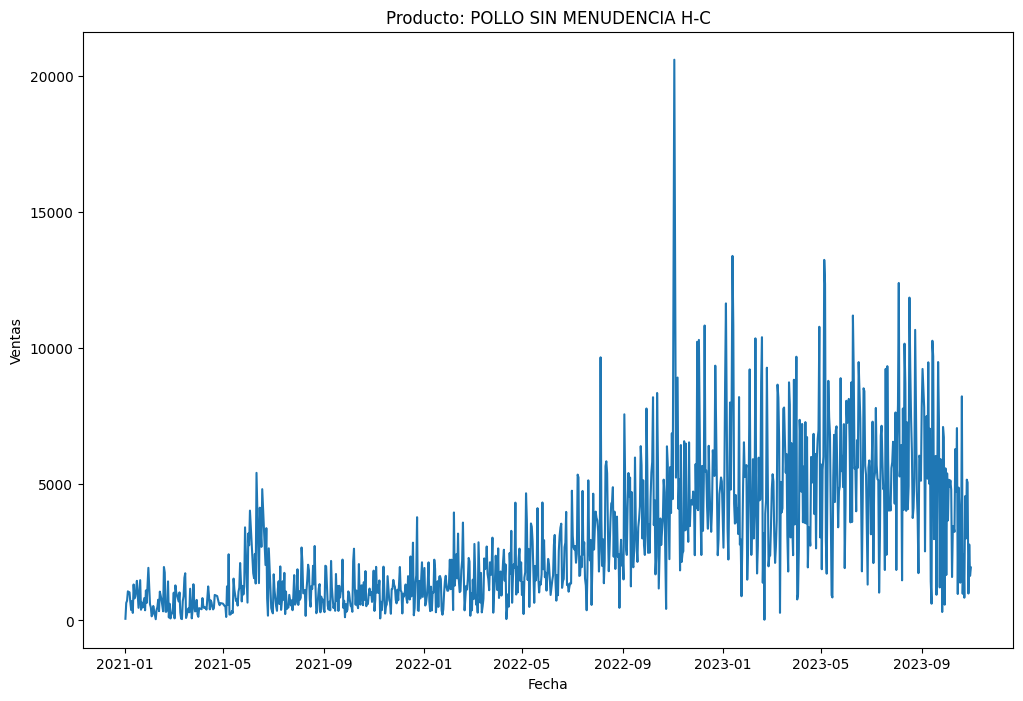

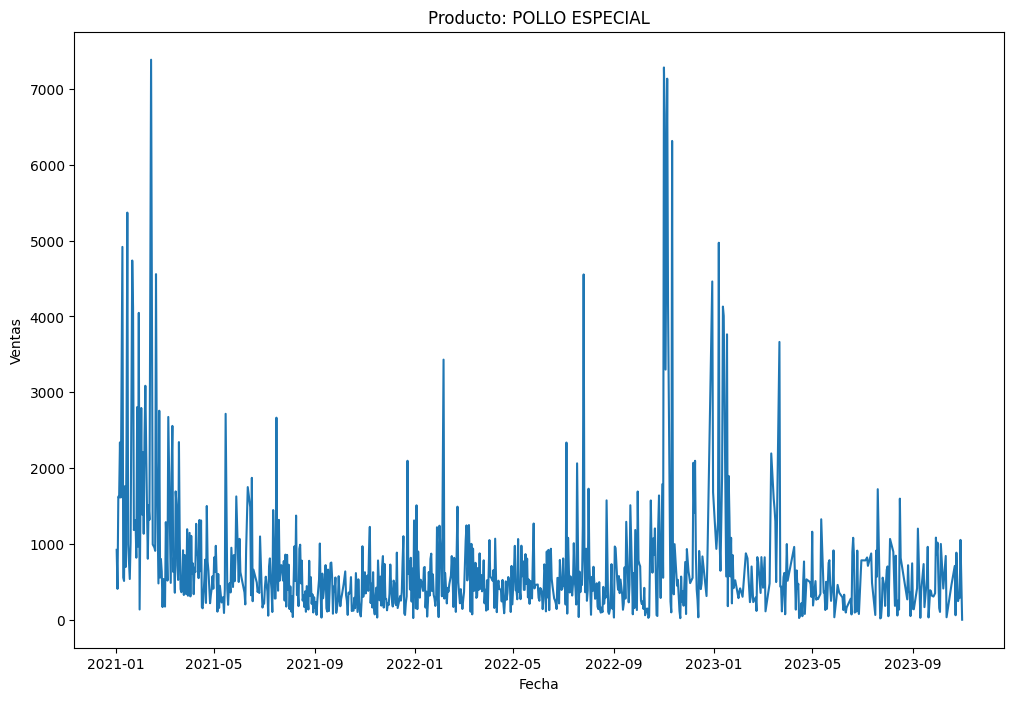

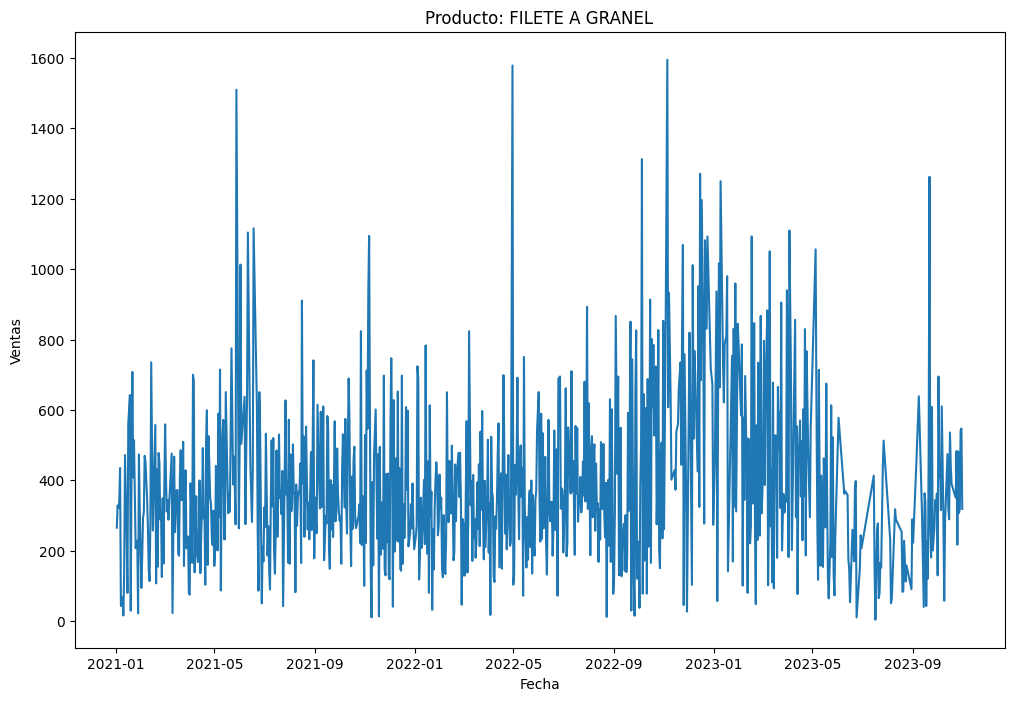

In [25]:
# Iterar sobre los productos y sus DataFrames
for i, (product, product_df) in enumerate(dfs_de_productos_sumados_prophet.items()):
    # Crear una nueva figura y ejes para cada producto
    fig, ax = plt.subplots(figsize=(12, 8))

    # Crear un gráfico de líneas para cada producto
    ax.plot(product_df['ds'], product_df['y'], label=product)
    ax.set_title(f'Producto: {product}')  # Utiliza 'set_title' en lugar de 'plt.set_title'
    ax.set_xlabel('Fecha')  # Utiliza 'set_xlabel' en lugar de 'plt.set_xlabel'
    ax.set_ylabel('Ventas')  # Utiliza 'set_ylabel' en lugar de 'plt.set_ylabel'

    # Mostrar el gráfico para el producto actual
    plt.show()

In [26]:
for i, df_product in enumerate(dfs_de_productos_sumados):
    print(f"DataFrame {i + 1} - Tipos de Datos:")
    print(dfs_de_productos_sumados[df_product].dtypes)
    print("=" * 30)

DataFrame 1 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
DataFrame 2 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
DataFrame 3 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object


### clonar para LSTM y ARIMA


In [27]:
dfs_de_productos_sumados

{'POLLO SIN MENUDENCIA H-C':                            NombreProducto  year  MontoBase
 FechaMovimiento                                           
 2021-01-02       POLLO SIN MENUDENCIA H-C  2021    59.2740
 2021-01-03       POLLO SIN MENUDENCIA H-C  2021   642.4020
 2021-01-04       POLLO SIN MENUDENCIA H-C  2021   724.1040
 2021-01-05       POLLO SIN MENUDENCIA H-C  2021  1069.3350
 2021-01-06       POLLO SIN MENUDENCIA H-C  2021  1014.0660
 ...                                   ...   ...        ...
 2023-10-27       POLLO SIN MENUDENCIA H-C  2023  5064.5984
 2023-10-28       POLLO SIN MENUDENCIA H-C  2023   987.0990
 2023-10-29       POLLO SIN MENUDENCIA H-C  2023  2787.4978
 2023-10-30       POLLO SIN MENUDENCIA H-C  2023  1635.4907
 2023-10-31       POLLO SIN MENUDENCIA H-C  2023  1943.9291
 
 [988 rows x 3 columns],
 'POLLO ESPECIAL':                  NombreProducto  year  MontoBase
 FechaMovimiento                                 
 2021-01-02       POLLO ESPECIAL  2021   922.04

In [28]:
# Clonar completamente el objeto contenedor de DataFrames sumados
dfs_de_productos_sumados_lstm = copy.deepcopy(dfs_de_productos_sumados)

# Iterar sobre los DataFrames en el nuevo objeto
for product, product_df_lstm in dfs_de_productos_sumados_lstm.items():
    # Restablecer el índice
    product_df_lstm.reset_index(inplace=True)
    print(product_df_lstm.head)
    print(product_df_lstm.dtypes)

    # Convertir 'FechaMovimiento' a tipo de dato datetime
    product_df_lstm['FechaMovimiento'] = pd.to_datetime(product_df_lstm['FechaMovimiento'])

    # Configurar 'FechaMovimiento' como índice
    product_df_lstm.set_index('FechaMovimiento', inplace=True)
    print(product_df_lstm.dtypes)

    # Preprocesamiento de fechas utilizando el índice
    product_df_lstm['DayOW'] = product_df_lstm.index.dayofweek
    product_df_lstm['Month'] = product_df_lstm.index.month
    product_df_lstm['Year'] = product_df_lstm.index.year

    product_df_lstm.drop(columns=['year'], inplace=True)

    # Ordenar el DataFrame por la fecha (si es necesario)
    product_df_lstm.sort_index(inplace=True)

<bound method NDFrame.head of     FechaMovimiento            NombreProducto  year  MontoBase
0        2021-01-02  POLLO SIN MENUDENCIA H-C  2021    59.2740
1        2021-01-03  POLLO SIN MENUDENCIA H-C  2021   642.4020
2        2021-01-04  POLLO SIN MENUDENCIA H-C  2021   724.1040
3        2021-01-05  POLLO SIN MENUDENCIA H-C  2021  1069.3350
4        2021-01-06  POLLO SIN MENUDENCIA H-C  2021  1014.0660
..              ...                       ...   ...        ...
983      2023-10-27  POLLO SIN MENUDENCIA H-C  2023  5064.5984
984      2023-10-28  POLLO SIN MENUDENCIA H-C  2023   987.0990
985      2023-10-29  POLLO SIN MENUDENCIA H-C  2023  2787.4978
986      2023-10-30  POLLO SIN MENUDENCIA H-C  2023  1635.4907
987      2023-10-31  POLLO SIN MENUDENCIA H-C  2023  1943.9291

[988 rows x 4 columns]>
FechaMovimiento     object
NombreProducto      object
year                 int64
MontoBase          float64
dtype: object
NombreProducto     object
year                int64
MontoBase      

In [29]:
# Clonar completamente el objeto contenedor de DataFrames sumados
dfs_de_productos_sumados_arima = copy.deepcopy(dfs_de_productos_sumados)

# Iterar sobre los DataFrames en el nuevo objeto
for product, product_df_arima in dfs_de_productos_sumados_arima.items():
     # Restablecer el índice
    product_df_arima.reset_index(inplace=True)
    print(product_df_arima.dtypes)
    product_df_arima['FechaMovimiento'] = pd.to_datetime(product_df_arima['FechaMovimiento'])
    product_df_arima['FechaMovimiento'] = product_df_arima['FechaMovimiento'].dt.date
    print(product_df_arima.dtypes)
    # Configurar 'FechaMovimiento' como índice
    product_df_arima.set_index('FechaMovimiento', inplace=True)

    # Ordenar el DataFrame por la fecha
    product_df_arima.sort_index(inplace=True)
    # Eliminar la columna 'year'
    product_df_arima.drop(columns=['year'], inplace=True)

FechaMovimiento     object
NombreProducto      object
year                 int64
MontoBase          float64
dtype: object
FechaMovimiento     object
NombreProducto      object
year                 int64
MontoBase          float64
dtype: object
FechaMovimiento     object
NombreProducto      object
year                 int64
MontoBase          float64
dtype: object
FechaMovimiento     object
NombreProducto      object
year                 int64
MontoBase          float64
dtype: object
FechaMovimiento     object
NombreProducto      object
year                 int64
MontoBase          float64
dtype: object
FechaMovimiento     object
NombreProducto      object
year                 int64
MontoBase          float64
dtype: object


In [30]:
print(list(dfs_de_productos_sumados_arima.values())[2])

                  NombreProducto  MontoBase
FechaMovimiento                            
2021-01-02       FILETE A GRANEL   265.6040
2021-01-03       FILETE A GRANEL   328.8080
2021-01-04       FILETE A GRANEL   321.0800
2021-01-05       FILETE A GRANEL   339.6640
2021-01-06       FILETE A GRANEL   435.1600
...                          ...        ...
2023-10-27       FILETE A GRANEL   307.0868
2023-10-28       FILETE A GRANEL   318.6604
2023-10-29       FILETE A GRANEL   541.5856
2023-10-30       FILETE A GRANEL   547.3632
2023-10-31       FILETE A GRANEL   318.9640

[878 rows x 2 columns]


## Noviembre
Antes de empezar con los modelos se debe Almacenar los valores de venta REALES de Noviembre de 2023 para comparar las predicciones de cada Modelo

In [31]:
# Crear un diccionario para almacenar los DataFrames divididos
dfs_de_Noviembre = {}

# Iterar sobre los productos y dividir el DataFrame
for product in top_3_productos['NombreProducto']:
    product_nov = df_noviembre[df_noviembre['NombreProducto'] == product].copy()

    product_nov.set_index('FechaMovimiento', inplace=True)


    # Almacenar el DataFrame en el diccionario
    dfs_de_Noviembre[product] = product_nov

In [32]:
# Crear un diccionario para almacenar los DataFrames sumados
dfs_noviembre_sumados = {}

# Iterar sobre los productos en el diccionario original
for product, product_df in dfs_de_Noviembre.items():
    # Sumar las ventas por día sin perder 'NombreProducto' y 'year'
    product_df_sumado = product_df.groupby(['FechaMovimiento', 'NombreProducto', 'year'])['MontoBase'].sum().reset_index()

    # Establecer 'FechaMovimiento' como índice
    product_df_sumado.set_index('FechaMovimiento', inplace=True)

    product_df_sumado.drop(columns=['year'], inplace=True)

    # Agregar el DataFrame sumado al nuevo diccionario
    dfs_noviembre_sumados[product] = product_df_sumado

    product_df_sumado = product_df_sumado.rename_axis('FechaMovimiento')

print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'])

                           NombreProducto  MontoBase
FechaMovimiento                                     
2023-11-01       POLLO SIN MENUDENCIA H-C  2476.3271
2023-11-02       POLLO SIN MENUDENCIA H-C  5469.8955
2023-11-03       POLLO SIN MENUDENCIA H-C  5823.3412
2023-11-04       POLLO SIN MENUDENCIA H-C  5385.7282
2023-11-05       POLLO SIN MENUDENCIA H-C  2729.9860
2023-11-06       POLLO SIN MENUDENCIA H-C   996.0257
2023-11-07       POLLO SIN MENUDENCIA H-C  1683.6664
2023-11-08       POLLO SIN MENUDENCIA H-C  3041.4504
2023-11-09       POLLO SIN MENUDENCIA H-C  5344.3076
2023-11-10       POLLO SIN MENUDENCIA H-C  3196.6041
2023-11-11       POLLO SIN MENUDENCIA H-C  1969.6056
2023-11-12       POLLO SIN MENUDENCIA H-C  4533.3930
2023-11-13       POLLO SIN MENUDENCIA H-C  3576.5896
2023-11-14       POLLO SIN MENUDENCIA H-C   605.9921
2023-11-15       POLLO SIN MENUDENCIA H-C  5202.4149
2023-11-16       POLLO SIN MENUDENCIA H-C  7216.1556
2023-11-17       POLLO SIN MENUDENCIA H-C  115

In [33]:
# Definir el rango de fechas de noviembre
noviembre_range = pd.date_range(start='2023-11-01', end='2023-11-30')

# Iterar sobre los productos en dfs_noviembre_sumados
for product, product_df in dfs_noviembre_sumados.items():
    # Crear un DataFrame con el índice de noviembre
    noviembre_df = pd.DataFrame(index=noviembre_range)

    # Verificar si hay fechas en noviembre que no están en el DataFrame original
    missing_dates = noviembre_df.index.difference(product_df.index)

    print(f"Las fechas que no están en el producto {product} son: {missing_dates}")

    if not missing_dates.empty:
        # Agregar filas con ventas '0' para las fechas faltantes
        new_rows = pd.DataFrame({'NombreProducto': product, 'MontoBase': 0}, index=missing_dates)

        # Convertir el índice a formato de fecha
        new_rows.index = pd.to_datetime(new_rows.index).date

        product_df = pd.concat([product_df, new_rows])

        # Asignar nombre al índice
        product_df.index.name = 'FechaMovimiento'

        print(f"Se agregaron filas con ventas '0' para el producto {product} en las fechas faltantes.")

    # Ordenar el DataFrame por fecha
    product_df.sort_index(inplace=True)

    # Imprimir información sobre el producto
    print(f"Se agregaron {len(missing_dates)} registros de venta 0 para el producto {product} en noviembre.")

    # Actualizar el DataFrame en el diccionario
    dfs_noviembre_sumados[product] = product_df

print(dfs_noviembre_sumados)

Las fechas que no están en el producto POLLO SIN MENUDENCIA H-C son: DatetimeIndex([], dtype='datetime64[ns]', freq='D')
Se agregaron 0 registros de venta 0 para el producto POLLO SIN MENUDENCIA H-C en noviembre.
Las fechas que no están en el producto POLLO ESPECIAL son: DatetimeIndex(['2023-11-11', '2023-11-12', '2023-11-22', '2023-11-23',
               '2023-11-24', '2023-11-26'],
              dtype='datetime64[ns]', freq=None)
Se agregaron filas con ventas '0' para el producto POLLO ESPECIAL en las fechas faltantes.
Se agregaron 6 registros de venta 0 para el producto POLLO ESPECIAL en noviembre.
Las fechas que no están en el producto FILETE A GRANEL son: DatetimeIndex(['2023-11-06', '2023-11-14', '2023-11-15', '2023-11-16',
               '2023-11-17'],
              dtype='datetime64[ns]', freq=None)
Se agregaron filas con ventas '0' para el producto FILETE A GRANEL en las fechas faltantes.
Se agregaron 5 registros de venta 0 para el producto FILETE A GRANEL en noviembre.
{'POLL

In [34]:
# print(dfs_noviembre_sumados)

# PROPHET


## Predecir cada uno de los 10 productos mas vendidos

 Predicciones sin el 2020 de los 10 productos más vendidos

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds            NombreProducto         y
0    2021-01-02  POLLO SIN MENUDENCIA H-C   59.2740
1    2021-01-03  POLLO SIN MENUDENCIA H-C  642.4020
2    2021-01-04  POLLO SIN MENUDENCIA H-C  724.1040
3    2021-01-05  POLLO SIN MENUDENCIA H-C 1069.3350
4    2021-01-06  POLLO SIN MENUDENCIA H-C 1014.0660
..          ...                       ...       ...
983  2023-10-27  POLLO SIN MENUDENCIA H-C 5064.5984
984  2023-10-28  POLLO SIN MENUDENCIA H-C  987.0990
985  2023-10-29  POLLO SIN MENUDENCIA H-C 2787.4978
986  2023-10-30  POLLO SIN MENUDENCIA H-C 1635.4907
987  2023-10-31  POLLO SIN MENUDENCIA H-C 1943.9291

[988 rows x 3 columns]


DEBUG:cmdstanpy:input tempfile: /tmp/tmp8f9gl1tc/rc2a1jey.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8f9gl1tc/l_3xzx5u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23307', 'data', 'file=/tmp/tmp8f9gl1tc/rc2a1jey.json', 'init=/tmp/tmp8f9gl1tc/l_3xzx5u.json', 'output', 'file=/tmp/tmp8f9gl1tc/prophet_modelofpvn_4z/prophet_model-20240303011907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:19:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:19:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


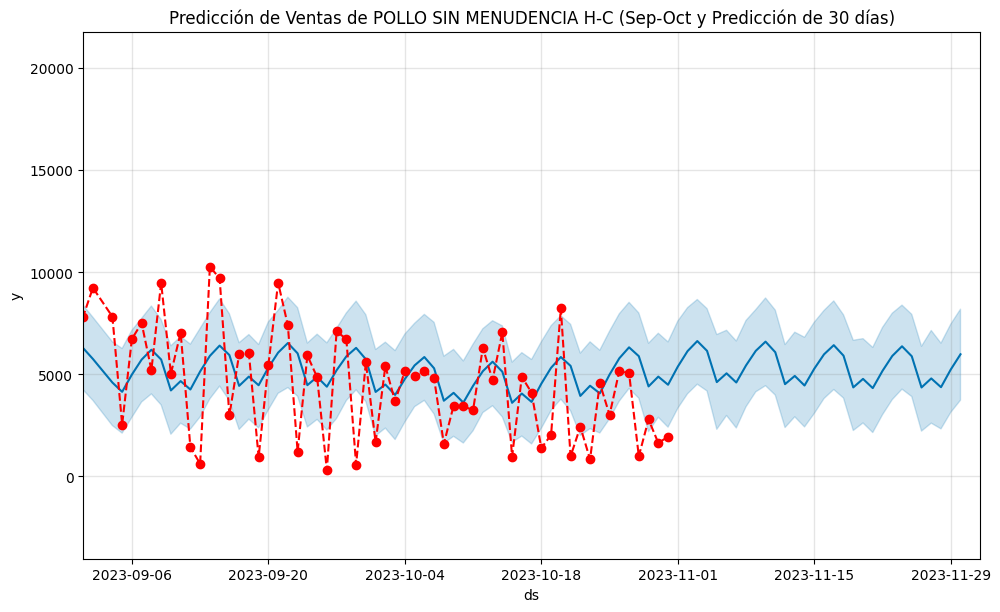

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8f9gl1tc/rh22_r5a.json


Predicción con todos los valores para POLLO SIN MENUDENCIA H-C:
             ds      yhat
988  2023-11-01 5375.7182
989  2023-11-02 6135.3640
990  2023-11-03 6628.6163
991  2023-11-04 6148.4578
992  2023-11-05 4617.7042
993  2023-11-06 5047.6671
994  2023-11-07 4598.5707
995  2023-11-08 5436.7291
996  2023-11-09 6149.8862
997  2023-11-10 6600.2425
998  2023-11-11 6081.6885
999  2023-11-12 4517.7918
1000 2023-11-13 4920.4441
1001 2023-11-14 4450.2665
1002 2023-11-15 5273.7818
1003 2023-11-16 5978.7546
1004 2023-11-17 6427.2235
1005 2023-11-18 5912.7457
1006 2023-11-19 4358.3992
1007 2023-11-20 4775.4501
1008 2023-11-21 4323.7809
1009 2023-11-22 5169.0891
1010 2023-11-23 5898.2552
1011 2023-11-24 6372.4039
1012 2023-11-25 5884.1783
1013 2023-11-26 4355.7703
1014 2023-11-27 4797.6147
1015 2023-11-28 4368.8418
1016 2023-11-29 5234.4978
1017 2023-11-30 5980.9299
             ds  NombreProducto         y
0    2021-01-02  POLLO ESPECIAL  922.0400
1    2021-01-03  POLLO ESPECIAL  406.9970
2   

DEBUG:cmdstanpy:input tempfile: /tmp/tmp8f9gl1tc/7qahb4ea.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85469', 'data', 'file=/tmp/tmp8f9gl1tc/rh22_r5a.json', 'init=/tmp/tmp8f9gl1tc/7qahb4ea.json', 'output', 'file=/tmp/tmp8f9gl1tc/prophet_model8j3k6k34/prophet_model-20240303011910.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:19:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:19:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


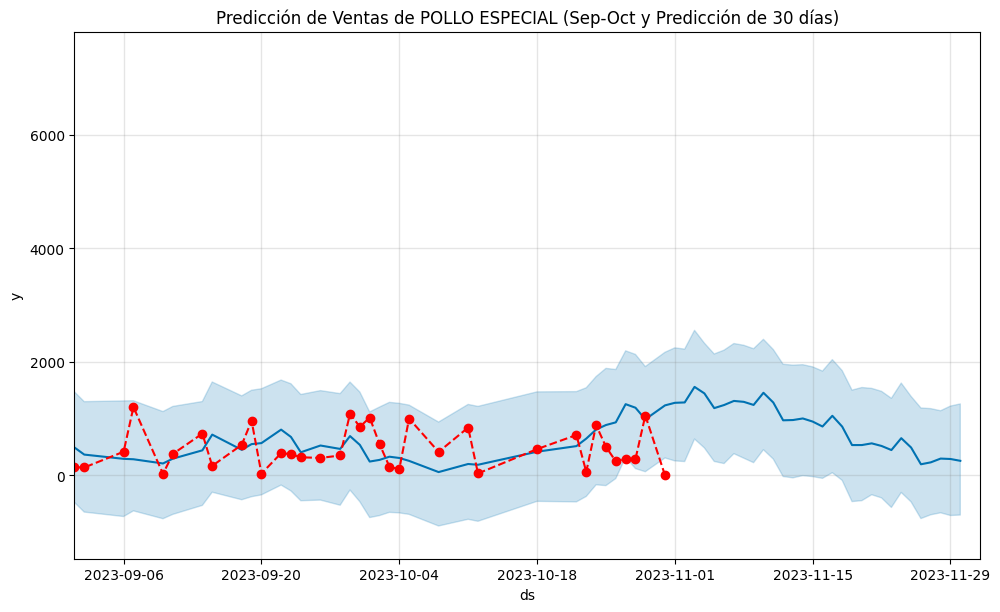

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8f9gl1tc/lvmpwzws.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8f9gl1tc/cy1spah7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48361', 'data', 'file=/tmp/tmp8f9gl1tc/lvmpwzws.json', 'init=/tmp/tmp8f9gl1tc/cy1spah7.json', 'output', 'file=/tmp/tmp8f9gl1tc/prophet_model0l1wc6d_/prophet_model-20240303011911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:19:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Predicción con todos los valores para POLLO ESPECIAL:
            ds      yhat
838 2023-11-01 1276.9033
839 2023-11-02 1283.3825
840 2023-11-03 1557.1963
841 2023-11-04 1443.0245
842 2023-11-05 1183.3643
843 2023-11-06 1237.7741
844 2023-11-07 1309.9209
845 2023-11-08 1293.9147
846 2023-11-09 1239.3820
847 2023-11-10 1453.5478
848 2023-11-11 1282.1378
849 2023-11-12  968.6302
850 2023-11-13  973.4789
851 2023-11-14 1001.1431
852 2023-11-15  946.4072
853 2023-11-16  859.4415
854 2023-11-17 1047.8761
855 2023-11-18  857.6981
856 2023-11-19  532.5010
857 2023-11-20  532.7103
858 2023-11-21  562.6186
859 2023-11-22  516.7133
860 2023-11-23  444.7487
861 2023-11-24  653.8339
862 2023-11-25  489.3453
863 2023-11-26  194.1940
864 2023-11-27  228.0696
865 2023-11-28  294.4945
866 2023-11-29  287.1709
867 2023-11-30  255.0716
             ds   NombreProducto        y
0    2021-01-02  FILETE A GRANEL 265.6040
1    2021-01-03  FILETE A GRANEL 328.8080
2    2021-01-04  FILETE A GRANEL 321.0800
3  

01:19:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


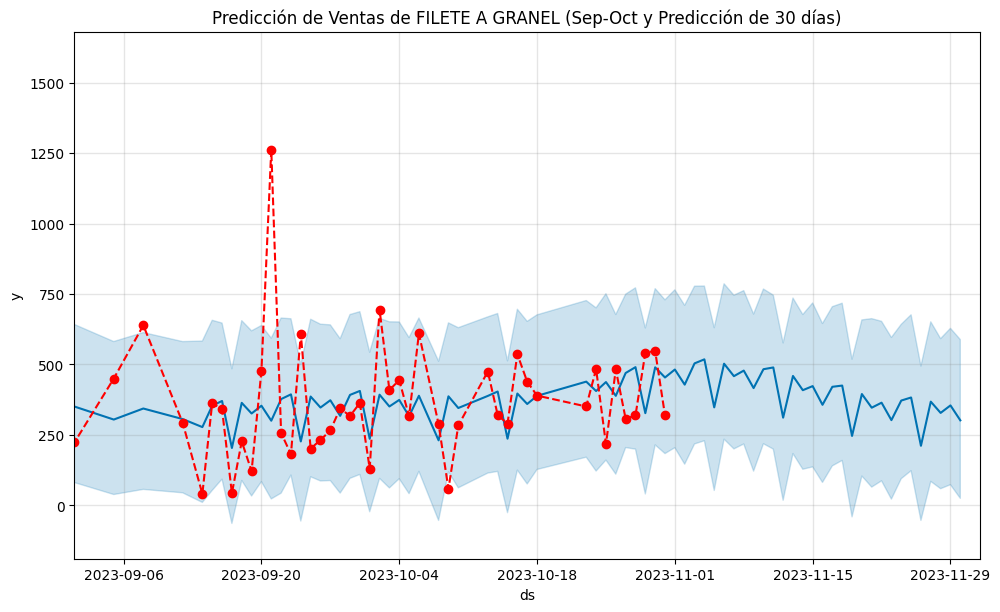

Predicción con todos los valores para FILETE A GRANEL:
            ds     yhat
878 2023-11-01 481.7552
879 2023-11-02 428.1875
880 2023-11-03 503.5824
881 2023-11-04 517.9361
882 2023-11-05 347.4326
883 2023-11-06 502.4486
884 2023-11-07 458.2216
885 2023-11-08 478.0030
886 2023-11-09 415.9274
887 2023-11-10 482.9114
888 2023-11-11 489.1344
889 2023-11-12 310.9600
890 2023-11-13 458.9369
891 2023-11-14 408.4624
892 2023-11-15 422.9315
893 2023-11-16 356.6031
894 2023-11-17 420.4945
895 2023-11-18 424.8605
896 2023-11-19 246.1125
897 2023-11-20 394.8181
898 2023-11-21 346.3639
899 2023-11-22 364.1049
900 2023-11-23 302.2315
901 2023-11-24 371.6652
902 2023-11-25 382.5409
903 2023-11-26 211.1280
904 2023-11-27 367.8333
905 2023-11-28 327.8686
906 2023-11-29 354.4033
907 2023-11-30 301.4363


In [35]:
# Definir las fechas de inicio y fin
fecha_inicio_str = '2023-09-01'
fecha_fin_str = '2023-12-02'

# Convertir las fechas a objetos datetime
fecha_inicio = datetime.strptime(fecha_inicio_str, '%Y-%m-%d')
fecha_fin = datetime.strptime(fecha_fin_str, '%Y-%m-%d')

# Iterar sobre los productos en dfs_de_productos_sumados_prophet
for product, product_df in dfs_de_productos_sumados_prophet.items():
    # Crear un modelo de Prophet
    modelo = Prophet()
    print(product_df)
    # Ajustar el modelo con los datos de entrenamiento
    modelo.fit(product_df)

    # Crear un DataFrame con fechas futuras para hacer la predicción
    futuro = modelo.make_future_dataframe(periods=30)

    # Hacer la predicción
    prediccion = modelo.predict(futuro)

    # Visualizar la predicción con límites ajustados
    fig = modelo.plot(prediccion)

    # Extraer los valores reales de predicción para cada día
    valores_prediccion = prediccion[['ds', 'yhat']].tail(30)

    # Mostrar el gráfico
    plt.plot(product_df['ds'], product_df['y'], label=f'Ventas reales de {product}', color='red', marker='o', linestyle='dashed')
    plt.xlim([fecha_inicio, fecha_fin])
    plt.title(f'Predicción de Ventas de {product} (Sep-Oct y Predicción de 30 días)')
    plt.show()

    # Mostrar el DataFrame con los valores de predicción
    print(f"Predicción con todos los valores para {product}:\n{valores_prediccion}")

    # Guardar las predicciones en dfs_noviembre_sumados
    col_name = f'P-V_PROPHET_{product}'
    dfs_noviembre_sumados[product][col_name] = valores_prediccion['yhat'].values

## EVALUAR PROPHET

Predicciones hechas sobre todas las ventas de los 10 producton contando con y sin las ventas de 2020

evaluacion sin 2020

In [36]:
# # Iterar sobre los productos en dfs_noviembre_sumados
# for product, product_df in dfs_noviembre_sumados.items():
#     # Crear un nombre único para la columna de predicciones de Prophet
#     col_name = f'P-V_PROPHET_{product}'

#     # Convertir la columna de fecha a tipo datetime
#     product_df['FechaMovimiento'] = pd.to_datetime(product_df.index)

#     # Fusionar el DataFrame de ventas con el DataFrame de predicciones
#     product_df = pd.merge(product_df, valores_prediccion[['ds', 'yhat']], left_on='FechaMovimiento', right_on='ds', how='left')

#     # Renombrar la columna yhat a Ventas_PROPHET
#     product_df.rename(columns={'yhat': col_name}, inplace=True)

#     # Opcional: Eliminar la columna adicional 'ds' si no la necesitas
#     product_df.drop(columns=['ds'], inplace=True)

#     # Actualizar el DataFrame en el diccionario
#     dfs_noviembre_sumados[product] = product_df

In [37]:
for product, product_df in dfs_noviembre_sumados.items():
    print(product_df.head(30))

    # Puedes acceder a cada DataFrame individualmente para realizar evaluaciones métricas
    evaluacion_metrica(dfs_noviembre_sumados[product]['MontoBase'], dfs_noviembre_sumados[product][f'P-V_PROPHET_{product}'])

                           NombreProducto  MontoBase  \
FechaMovimiento                                        
2023-11-01       POLLO SIN MENUDENCIA H-C  2476.3271   
2023-11-02       POLLO SIN MENUDENCIA H-C  5469.8955   
2023-11-03       POLLO SIN MENUDENCIA H-C  5823.3412   
2023-11-04       POLLO SIN MENUDENCIA H-C  5385.7282   
2023-11-05       POLLO SIN MENUDENCIA H-C  2729.9860   
2023-11-06       POLLO SIN MENUDENCIA H-C   996.0257   
2023-11-07       POLLO SIN MENUDENCIA H-C  1683.6664   
2023-11-08       POLLO SIN MENUDENCIA H-C  3041.4504   
2023-11-09       POLLO SIN MENUDENCIA H-C  5344.3076   
2023-11-10       POLLO SIN MENUDENCIA H-C  3196.6041   
2023-11-11       POLLO SIN MENUDENCIA H-C  1969.6056   
2023-11-12       POLLO SIN MENUDENCIA H-C  4533.3930   
2023-11-13       POLLO SIN MENUDENCIA H-C  3576.5896   
2023-11-14       POLLO SIN MENUDENCIA H-C   605.9921   
2023-11-15       POLLO SIN MENUDENCIA H-C  5202.4149   
2023-11-16       POLLO SIN MENUDENCIA H-C  7216.

In [38]:
dfs_noviembre_sumados

{'POLLO SIN MENUDENCIA H-C':                            NombreProducto  MontoBase  \
 FechaMovimiento                                        
 2023-11-01       POLLO SIN MENUDENCIA H-C  2476.3271   
 2023-11-02       POLLO SIN MENUDENCIA H-C  5469.8955   
 2023-11-03       POLLO SIN MENUDENCIA H-C  5823.3412   
 2023-11-04       POLLO SIN MENUDENCIA H-C  5385.7282   
 2023-11-05       POLLO SIN MENUDENCIA H-C  2729.9860   
 2023-11-06       POLLO SIN MENUDENCIA H-C   996.0257   
 2023-11-07       POLLO SIN MENUDENCIA H-C  1683.6664   
 2023-11-08       POLLO SIN MENUDENCIA H-C  3041.4504   
 2023-11-09       POLLO SIN MENUDENCIA H-C  5344.3076   
 2023-11-10       POLLO SIN MENUDENCIA H-C  3196.6041   
 2023-11-11       POLLO SIN MENUDENCIA H-C  1969.6056   
 2023-11-12       POLLO SIN MENUDENCIA H-C  4533.3930   
 2023-11-13       POLLO SIN MENUDENCIA H-C  3576.5896   
 2023-11-14       POLLO SIN MENUDENCIA H-C   605.9921   
 2023-11-15       POLLO SIN MENUDENCIA H-C  5202.4149   
 20

# LSTM


In [39]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [40]:
print(dfs_de_productos_sumados_lstm['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_de_productos_sumados_lstm)

NombreProducto     object
MontoBase         float64
DayOW               int64
Month               int64
Year                int64
dtype: object
{'POLLO SIN MENUDENCIA H-C':                            NombreProducto  MontoBase  DayOW  Month  Year
FechaMovimiento                                                         
2021-01-02       POLLO SIN MENUDENCIA H-C    59.2740      5      1  2021
2021-01-03       POLLO SIN MENUDENCIA H-C   642.4020      6      1  2021
2021-01-04       POLLO SIN MENUDENCIA H-C   724.1040      0      1  2021
2021-01-05       POLLO SIN MENUDENCIA H-C  1069.3350      1      1  2021
2021-01-06       POLLO SIN MENUDENCIA H-C  1014.0660      2      1  2021
...                                   ...        ...    ...    ...   ...
2023-10-27       POLLO SIN MENUDENCIA H-C  5064.5984      4     10  2023
2023-10-28       POLLO SIN MENUDENCIA H-C   987.0990      5     10  2023
2023-10-29       POLLO SIN MENUDENCIA H-C  2787.4978      6     10  2023
2023-10-30       POLLO S

In [41]:
# Función para crear secuencias temporales
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append((seq, label))
    return np.array([s[0] for s in sequences]), np.array([s[1] for s in sequences])


## Entrenamiento y prediccion para cada producto
Aquellos productos que despues de 01-09-2023 no tienen mas de 30 ventas, no tienen predicciones para el mes de Noviembre

Epoch 1/50
24/24 - 3s - loss: 0.0094 - 3s/epoch - 144ms/step
Epoch 2/50
24/24 - 0s - loss: 0.0069 - 445ms/epoch - 19ms/step
Epoch 3/50
24/24 - 1s - loss: 0.0066 - 632ms/epoch - 26ms/step
Epoch 4/50
24/24 - 1s - loss: 0.0067 - 649ms/epoch - 27ms/step
Epoch 5/50
24/24 - 1s - loss: 0.0069 - 630ms/epoch - 26ms/step
Epoch 6/50
24/24 - 1s - loss: 0.0067 - 666ms/epoch - 28ms/step
Epoch 7/50
24/24 - 1s - loss: 0.0066 - 668ms/epoch - 28ms/step
Epoch 8/50
24/24 - 1s - loss: 0.0065 - 696ms/epoch - 29ms/step
Epoch 9/50
24/24 - 0s - loss: 0.0065 - 475ms/epoch - 20ms/step
Epoch 10/50
24/24 - 0s - loss: 0.0065 - 397ms/epoch - 17ms/step
Epoch 11/50
24/24 - 0s - loss: 0.0065 - 390ms/epoch - 16ms/step
Epoch 12/50
24/24 - 0s - loss: 0.0064 - 410ms/epoch - 17ms/step
Epoch 13/50
24/24 - 0s - loss: 0.0066 - 413ms/epoch - 17ms/step
Epoch 14/50
24/24 - 0s - loss: 0.0064 - 396ms/epoch - 17ms/step
Epoch 15/50
24/24 - 0s - loss: 0.0064 - 406ms/epoch - 17ms/step
Epoch 16/50
24/24 - 0s - loss: 0.0064 - 409ms/epoch

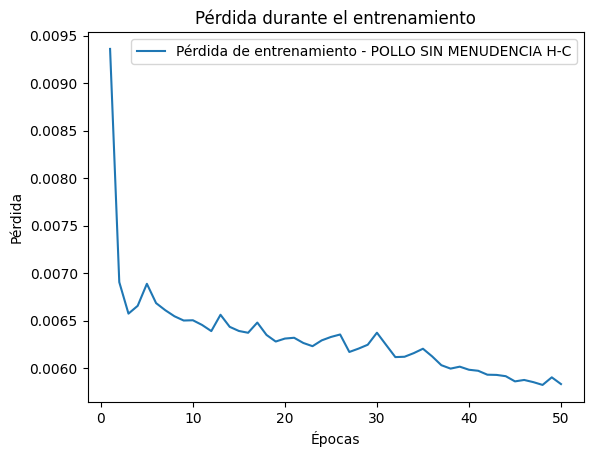

6/6 [==============================] - 1s 8ms/step


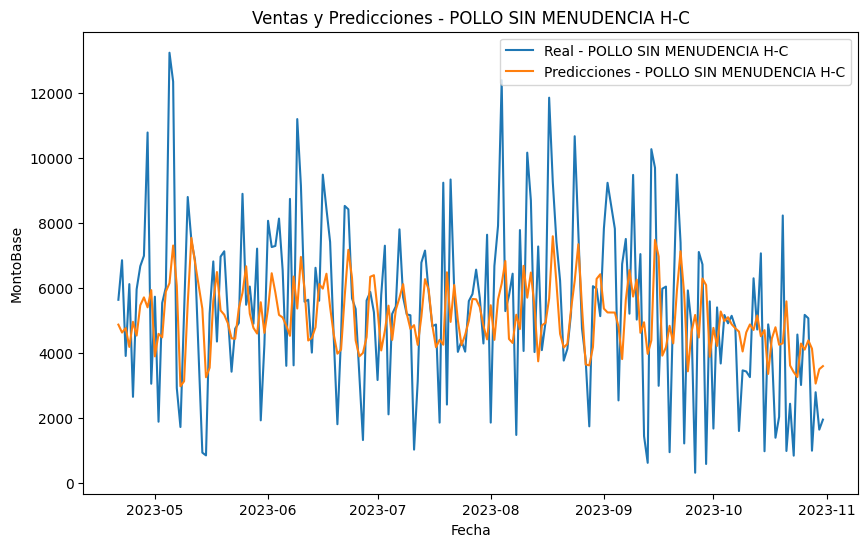

Dimensiones de fechas: (193,)
Dimensiones de predicciones: (192, 1)
La longitud de X_test es: 192 y la longitud de y_test es: 192
Forma de input_data: (30, 30, 1)
1/1 [==============================] - 0s 493ms/step
                 P-V_LSTM_POLLO SIN MENUDENCIA H-C
FechaMovimiento                                   
2023-11-01                                       0
2023-11-02                                       0
2023-11-03                                       0
2023-11-04                                       0
2023-11-05                                       0
2023-11-06                                       0
2023-11-07                                       0
2023-11-08                                       0
2023-11-09                                       0
2023-11-10                                       0
2023-11-11                                       0
2023-11-12                                       0
2023-11-13                                       0
2023-11-14         

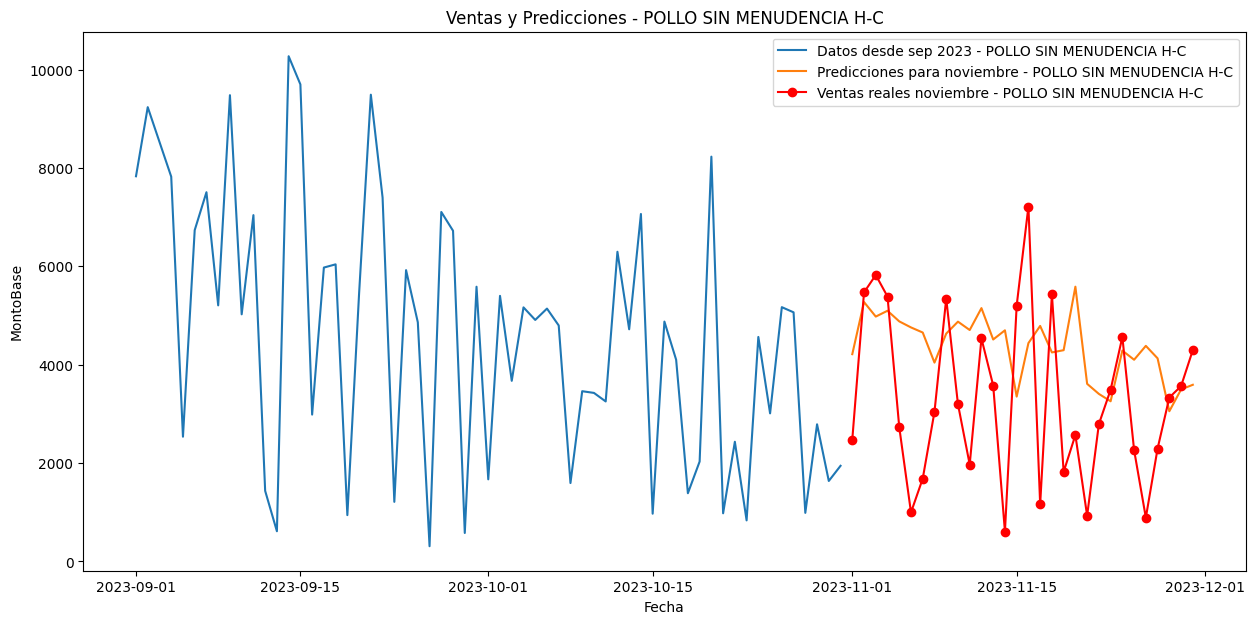

Epoch 1/50
21/21 - 3s - loss: 0.0129 - 3s/epoch - 133ms/step
Epoch 2/50
21/21 - 0s - loss: 0.0116 - 495ms/epoch - 24ms/step
Epoch 3/50
21/21 - 1s - loss: 0.0113 - 597ms/epoch - 28ms/step
Epoch 4/50
21/21 - 1s - loss: 0.0112 - 585ms/epoch - 28ms/step
Epoch 5/50
21/21 - 1s - loss: 0.0113 - 546ms/epoch - 26ms/step
Epoch 6/50
21/21 - 1s - loss: 0.0112 - 565ms/epoch - 27ms/step
Epoch 7/50
21/21 - 1s - loss: 0.0111 - 580ms/epoch - 28ms/step
Epoch 8/50
21/21 - 1s - loss: 0.0110 - 586ms/epoch - 28ms/step
Epoch 9/50
21/21 - 1s - loss: 0.0111 - 598ms/epoch - 28ms/step
Epoch 10/50
21/21 - 0s - loss: 0.0111 - 402ms/epoch - 19ms/step
Epoch 11/50
21/21 - 0s - loss: 0.0111 - 347ms/epoch - 17ms/step
Epoch 12/50
21/21 - 0s - loss: 0.0109 - 352ms/epoch - 17ms/step
Epoch 13/50
21/21 - 0s - loss: 0.0110 - 366ms/epoch - 17ms/step
Epoch 14/50
21/21 - 0s - loss: 0.0108 - 346ms/epoch - 16ms/step
Epoch 15/50
21/21 - 0s - loss: 0.0108 - 353ms/epoch - 17ms/step
Epoch 16/50
21/21 - 0s - loss: 0.0108 - 358ms/epoch

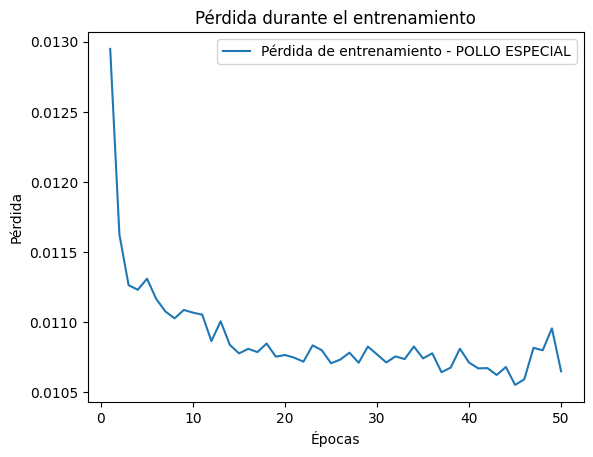

6/6 [==============================] - 1s 8ms/step


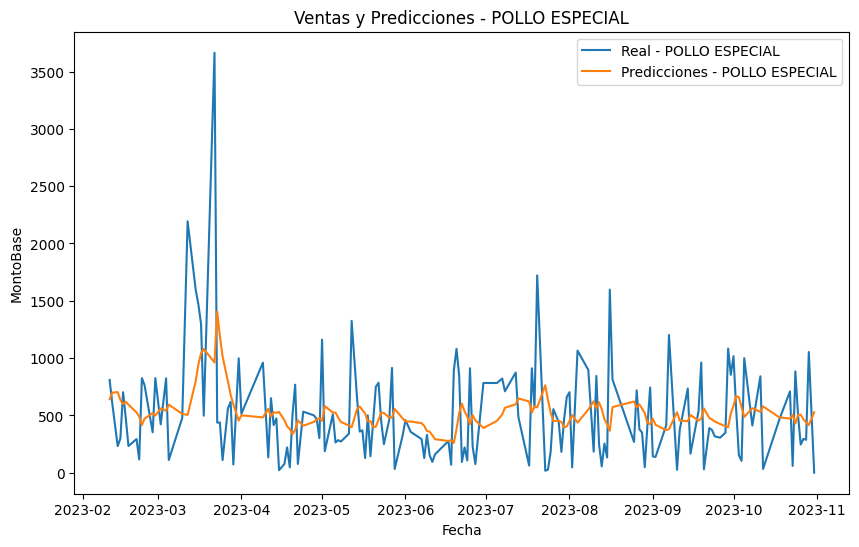

Dimensiones de fechas: (163,)
Dimensiones de predicciones: (162, 1)
La longitud de X_test es: 162 y la longitud de y_test es: 162
Forma de input_data: (30, 30, 1)
1/1 [==============================] - 0s 58ms/step
                 P-V_LSTM_POLLO ESPECIAL
FechaMovimiento                         
2023-11-01                             0
2023-11-02                             0
2023-11-03                             0
2023-11-04                             0
2023-11-05                             0
2023-11-06                             0
2023-11-07                             0
2023-11-08                             0
2023-11-09                             0
2023-11-10                             0
2023-11-11                             0
2023-11-12                             0
2023-11-13                             0
2023-11-14                             0
2023-11-15                             0
2023-11-16                             0
2023-11-17                             0
2023-1

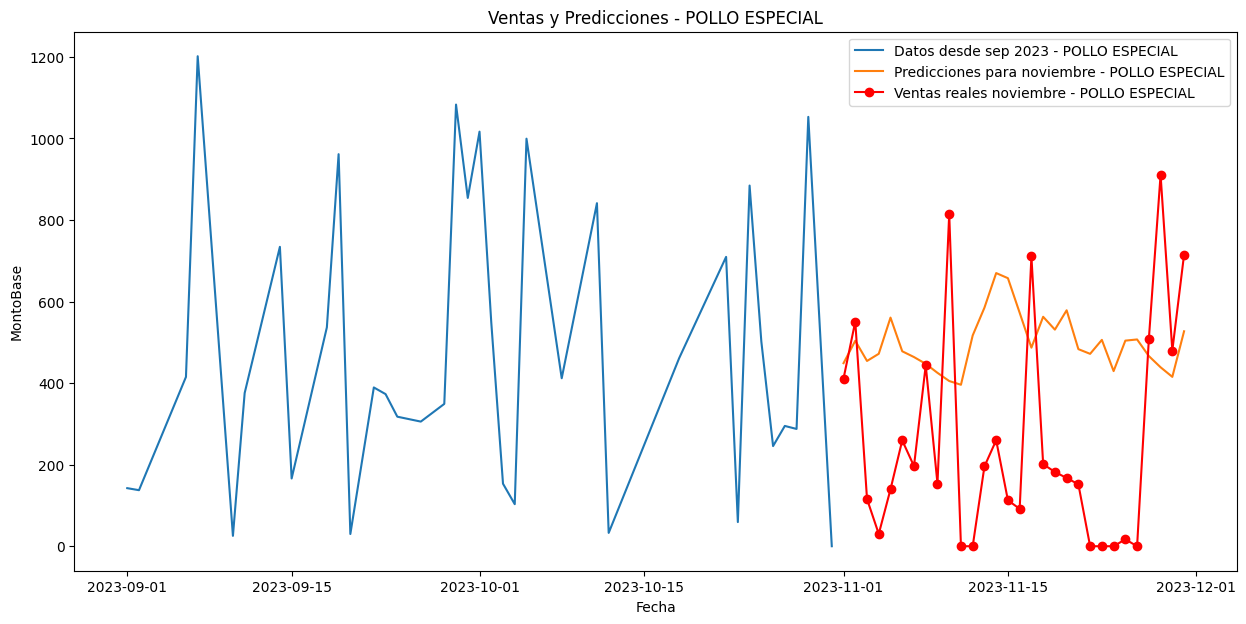

Epoch 1/50
22/22 - 3s - loss: 0.0385 - 3s/epoch - 158ms/step
Epoch 2/50
22/22 - 0s - loss: 0.0210 - 360ms/epoch - 16ms/step
Epoch 3/50
22/22 - 0s - loss: 0.0200 - 377ms/epoch - 17ms/step
Epoch 4/50
22/22 - 0s - loss: 0.0200 - 376ms/epoch - 17ms/step
Epoch 5/50
22/22 - 0s - loss: 0.0200 - 376ms/epoch - 17ms/step
Epoch 6/50
22/22 - 0s - loss: 0.0200 - 390ms/epoch - 18ms/step
Epoch 7/50
22/22 - 0s - loss: 0.0199 - 377ms/epoch - 17ms/step
Epoch 8/50
22/22 - 1s - loss: 0.0201 - 773ms/epoch - 35ms/step
Epoch 9/50
22/22 - 1s - loss: 0.0199 - 879ms/epoch - 40ms/step
Epoch 10/50
22/22 - 0s - loss: 0.0200 - 378ms/epoch - 17ms/step
Epoch 11/50
22/22 - 0s - loss: 0.0198 - 371ms/epoch - 17ms/step
Epoch 12/50
22/22 - 0s - loss: 0.0199 - 397ms/epoch - 18ms/step
Epoch 13/50
22/22 - 0s - loss: 0.0201 - 377ms/epoch - 17ms/step
Epoch 14/50
22/22 - 0s - loss: 0.0199 - 373ms/epoch - 17ms/step
Epoch 15/50
22/22 - 0s - loss: 0.0197 - 387ms/epoch - 18ms/step
Epoch 16/50
22/22 - 0s - loss: 0.0202 - 369ms/epoch

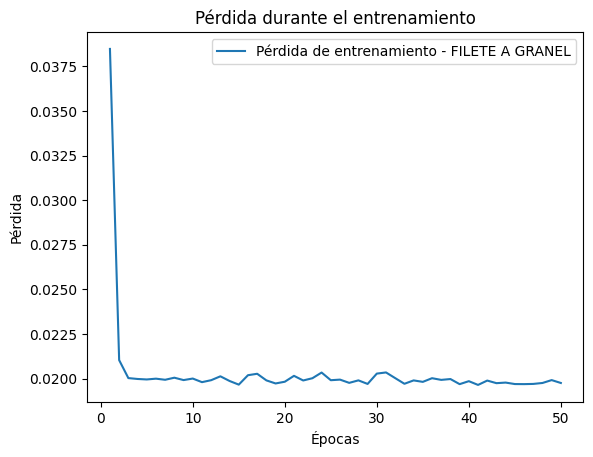

6/6 [==============================] - 1s 11ms/step


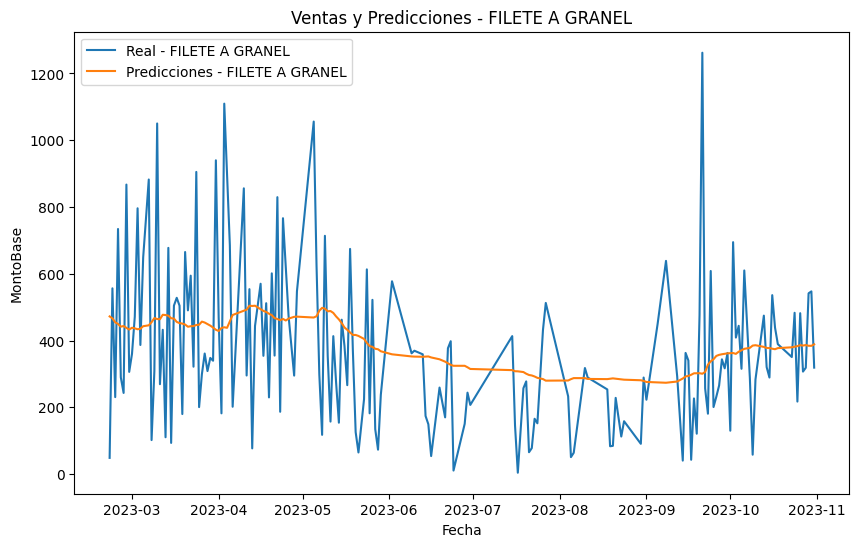

Dimensiones de fechas: (171,)
Dimensiones de predicciones: (170, 1)
La longitud de X_test es: 170 y la longitud de y_test es: 170
Forma de input_data: (30, 30, 1)
1/1 [==============================] - 0s 51ms/step
                 P-V_LSTM_FILETE A GRANEL
FechaMovimiento                          
2023-11-01                              0
2023-11-02                              0
2023-11-03                              0
2023-11-04                              0
2023-11-05                              0
2023-11-06                              0
2023-11-07                              0
2023-11-08                              0
2023-11-09                              0
2023-11-10                              0
2023-11-11                              0
2023-11-12                              0
2023-11-13                              0
2023-11-14                              0
2023-11-15                              0
2023-11-16                              0
2023-11-17                   

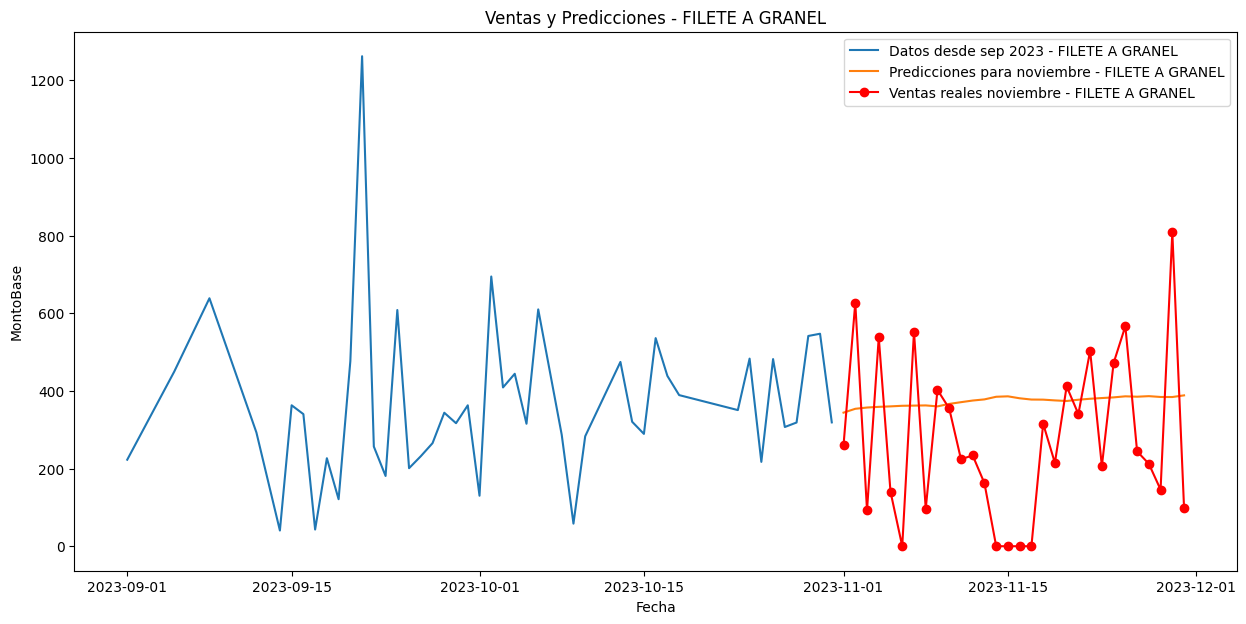

In [42]:
# Crear un DataFrame con fechas de noviembre y valores inicializados en 0
fechas_noviembre = pd.date_range(start='2023-11-01', end='2023-11-30')
# predicciones_df_lstm = pd.DataFrame()
# predicciones_df_lstm['FechaMovimiento'] = fechas_noviembre
# predicciones_df_lstm[f'P-V_LSTM_{product}'] = 0

# Iterar sobre los DataFrames en el objeto dfs_de_productos_sumados_lstm
for product, product_df_lstm in dfs_de_productos_sumados_lstm.items():

    # Normalizar los datos
    scaler = MinMaxScaler(feature_range=(0, 1))
    product_df_lstm['MontoBase_scaler'] = scaler.fit_transform(product_df_lstm['MontoBase'].values.reshape(-1, 1))

    # Crear secuencias temporales
    seq_length = 30
    X, y = create_sequences(product_df_lstm['MontoBase_scaler'].values, seq_length)

    # Dividir en conjuntos de entrenamiento y prueba
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Reshape para el modelo LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Construir el modelo LSTM
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Entrenar el modelo
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

    # Visualizar la pérdida durante el entrenamiento
    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, label=f'Pérdida de entrenamiento - {product}')
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()
    # Hacer predicciones en el conjunto de prueba
    predictions = model.predict(X_test)

    # Desnormalizar las predicciones
    predictions = scaler.inverse_transform(predictions)

    # Visualizar las predicciones
    plt.figure(figsize=(10, 6))
    plt.plot(product_df_lstm.index[train_size+seq_length:], product_df_lstm['MontoBase'].values[train_size+seq_length:], label='Real - ' + product)
    plt.plot(product_df_lstm.index[train_size+seq_length:], predictions, label='Predicciones - ' + product)
    plt.title('Ventas y Predicciones - ' + product)
    plt.xlabel('Fecha')
    plt.ylabel('MontoBase')
    plt.legend()
    plt.show()

    # Hacer predicciones para el futuro
    last_days = product_df_lstm.tail(60)  # Últimos 30 días
    input_data = last_days['MontoBase'].values
    input_data = scaler.transform(input_data.reshape(-1, 1))

    print("Dimensiones de fechas:", product_df_lstm.index[train_size+seq_length-1:].shape)
    print("Dimensiones de predicciones:", predictions.shape)
    print(f'La longitud de X_test es: {X_test.shape[0]} y la longitud de y_test es: {y_test.shape[0]}')

    input_data, _ = create_sequences(input_data, seq_length)

    # Imprimir la forma de input_data para depuración
    print("Forma de input_data:", input_data.shape)

    # Hacer predicciones para el futuro
    predictions_future = model.predict(input_data)
    #predictions_future_nov = model.predict(last_data)

    # Crear un DataFrame con fechas de noviembre y valores inicializados en 0
    predicciones_df_lstm = pd.DataFrame(index=fechas_noviembre)
    predicciones_df_lstm['FechaMovimiento'] = fechas_noviembre  # Agregar la columna de fechas
    predicciones_df_lstm.set_index('FechaMovimiento', inplace=True)
    predicciones_df_lstm[f'P-V_LSTM_{product}'] = 0

    # Imprimir el DataFrame inicial para depuración
    print(predicciones_df_lstm)

    # Desnormalizar las predicciones
    predictions_future = scaler.inverse_transform(predictions_future)

    # Actualizar las predicciones reales en las fechas correspondientes
    predicciones_df_lstm.loc[fechas_noviembre[:len(predictions_future)], f'P-V_LSTM_{product}'] = predictions_future.flatten()

    # Imprimir el DataFrame actualizado para depuración
    print(predicciones_df_lstm)

    # Agregar la columna al DataFrame original
    dfs_noviembre_sumados[product][f'P-V_LSTM_{product}'] = predicciones_df_lstm[f'P-V_LSTM_{product}']

    # Visualizar los resultados
    plt.figure(figsize=(15, 7))
    # Datos de venta desde el 1ro de septiembre de 2023
    start_date = '2023-09-01'
    end_date = '2023-11-30'
    plt.plot(product_df_lstm.index[product_df_lstm.index >= start_date], product_df_lstm['MontoBase'][product_df_lstm.index >= start_date], label='Datos desde sep 2023 - ' + product)
    # Predicciones para el futuro (noviembre)
    dates_future = pd.date_range(start='2023-11-01', periods=len(predictions_future))
    plt.plot(dates_future[:len(predictions_future)], predictions_future, label='Predicciones para noviembre - ' + product)
    # Datos reales de noviembre
    real_november_data = dfs_noviembre_sumados[product]
    plt.plot(real_november_data.index, real_november_data['MontoBase'], 'o-', color='red', label='Ventas reales noviembre - ' + product)
    plt.title('Ventas y Predicciones - ' + product)
    plt.xlabel('Fecha')
    plt.ylabel('MontoBase')
    plt.legend()
    plt.show()

In [43]:
print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_noviembre_sumados)

NombreProducto                           object
MontoBase                               float64
P-V_PROPHET_POLLO SIN MENUDENCIA H-C    float64
P-V_LSTM_POLLO SIN MENUDENCIA H-C       float32
dtype: object
{'POLLO SIN MENUDENCIA H-C':                            NombreProducto  MontoBase  \
FechaMovimiento                                        
2023-11-01       POLLO SIN MENUDENCIA H-C  2476.3271   
2023-11-02       POLLO SIN MENUDENCIA H-C  5469.8955   
2023-11-03       POLLO SIN MENUDENCIA H-C  5823.3412   
2023-11-04       POLLO SIN MENUDENCIA H-C  5385.7282   
2023-11-05       POLLO SIN MENUDENCIA H-C  2729.9860   
2023-11-06       POLLO SIN MENUDENCIA H-C   996.0257   
2023-11-07       POLLO SIN MENUDENCIA H-C  1683.6664   
2023-11-08       POLLO SIN MENUDENCIA H-C  3041.4504   
2023-11-09       POLLO SIN MENUDENCIA H-C  5344.3076   
2023-11-10       POLLO SIN MENUDENCIA H-C  3196.6041   
2023-11-11       POLLO SIN MENUDENCIA H-C  1969.6056   
2023-11-12       POLLO SIN MENUDENCIA

## Evaluar LSTM




In [44]:
for product, product_df in dfs_noviembre_sumados.items():
    # print(product_df.head(30))

    # Verificar si la columna 'P-V_LSTM_{product}' existe
    if f'P-V_LSTM_{product}' in dfs_noviembre_sumados[product].columns:
        print(f'evaluacion del producto: {product}')
        # Puedes acceder a cada DataFrame individualmente para realizar evaluaciones métricas
        evaluacion_metrica(
            dfs_noviembre_sumados[product]['MontoBase'],
            dfs_noviembre_sumados[product][f'P-V_LSTM_{product}']
        )
        print('\n')
    else:
        print(f"No hay predicciones para {product}.")

evaluacion del producto: POLLO SIN MENUDENCIA H-C
Evaluation metric results:  
MSE is : 4313989.825860251
MAE is : 1689.225374166667
R2 is : -0.496089364538812 %
------------------------------
MRSE is : 2077.014642668715
MAPE is : 108.18113193850792 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------




evaluacion del producto: POLLO ESPECIAL
Evaluation metric results:  
MSE is : 137545.39354675566
MAE is : 334.6468309114583
R2 is : -1.0181058802251348 %
------------------------------
MRSE is : 370.8711279497983
MAPE is : 322.7998600348814 %
------------------------------
------------------------------
Días reales calculados: 24
Días omitidos: 6
Total de días: 30
------------------------------




evaluacion del producto: FILETE A GRANEL
Evaluation metric results:  
MSE is : 54538.37547150928
MAE is : 202.04720763671872
R2 is : -0.24125027647081576 %
------------------------------


# ARIMA

In [45]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.7 MB/s eta 0:00:00


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
#from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima import auto_arima

In [47]:
dfs_de_productos_sumados_arima['POLLO SIN MENUDENCIA H-C'].dtypes

NombreProducto     object
MontoBase         float64
dtype: object

In [48]:
dfs_de_productos_sumados_arima['POLLO SIN MENUDENCIA H-C'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 988 entries, 2021-01-02 to 2023-10-31
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   NombreProducto  988 non-null    object 
 1   MontoBase       988 non-null    float64
dtypes: float64(1), object(1)
memory usage: 23.2+ KB


Predicciones para POLLO SIN MENUDENCIA H-C:


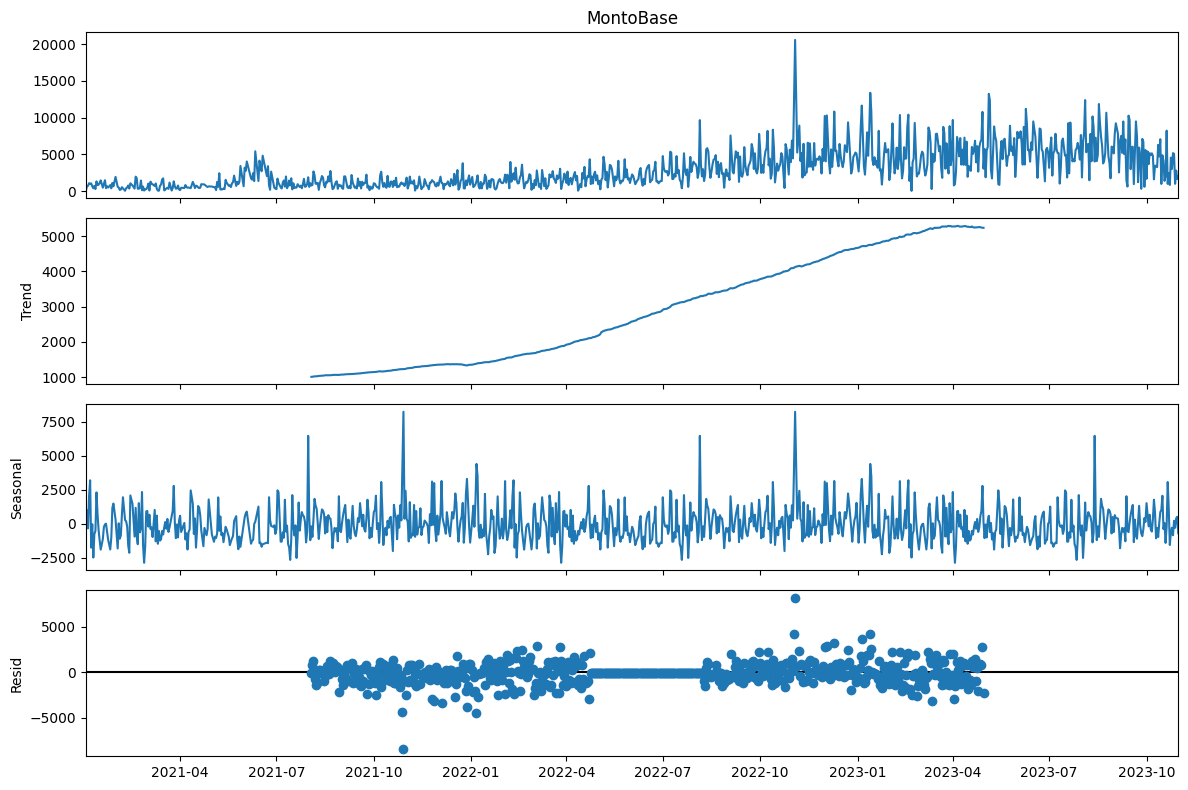

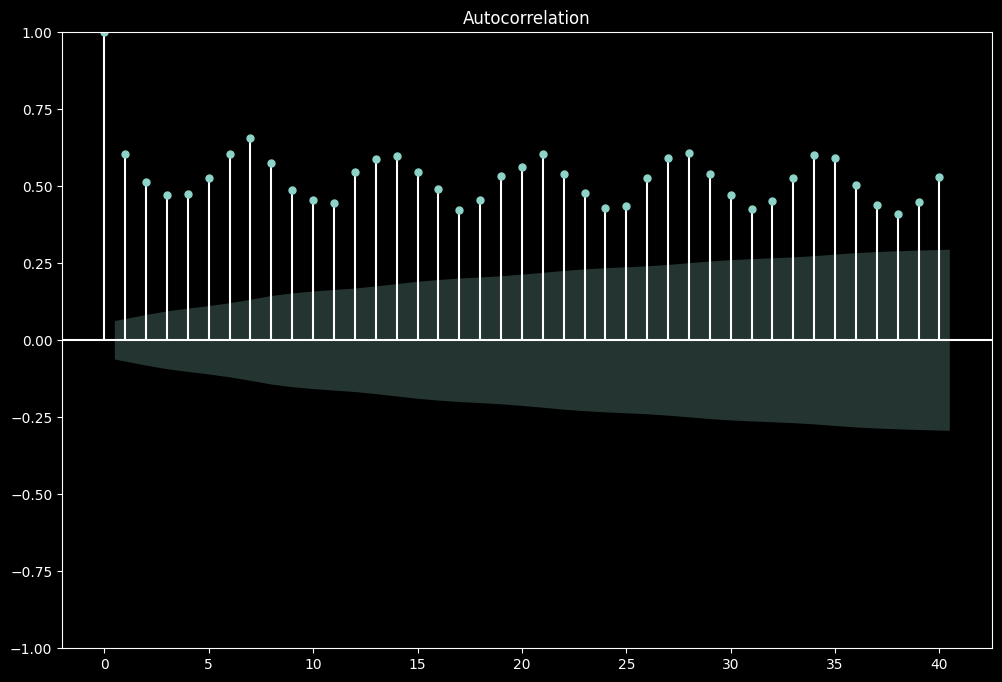

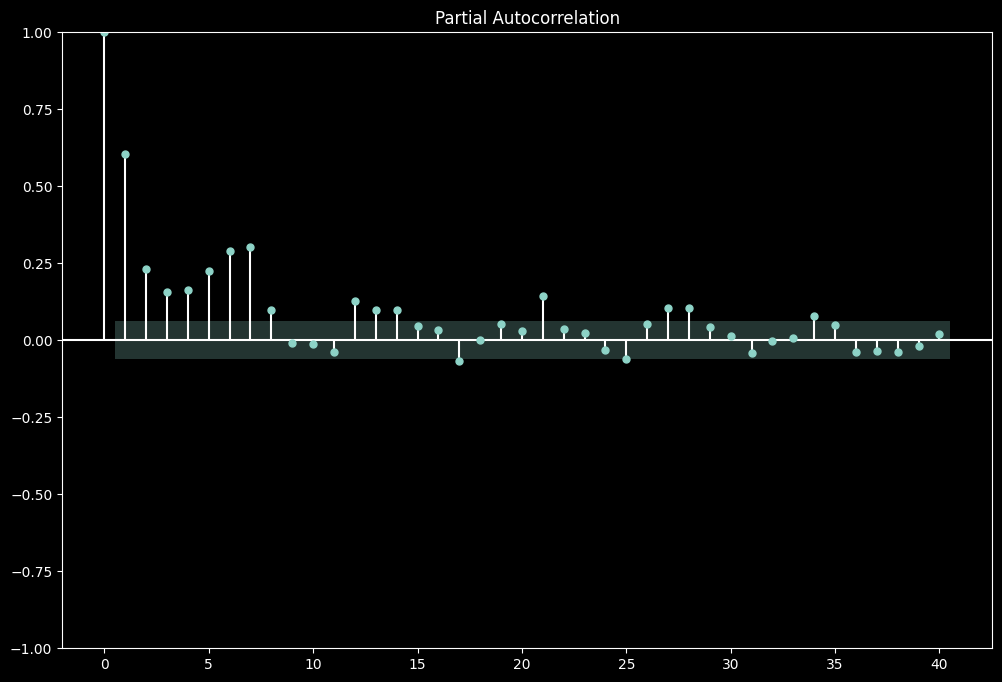

(957, 2) (31, 2)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=17893.359, Time=0.40 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=17614.596, Time=2.57 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=7.66 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=17766.253, Time=0.33 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=17465.369, Time=16.44 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=24.39 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=9.47 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=17597.997, Time=5.91 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=17387.590, Time=11.34 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=17574.298, Time=2.13 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=19.77 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=5.65 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=17347.770, Time=13.44 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=17525.803, Time=1.74 sec
 ARIMA(3,1,0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

2023-10-01   2995.6637
2023-10-02   1576.6159
2023-10-03   5908.7989
2023-10-04   3847.2961
2023-10-05   1821.5064
2023-10-06   2681.1424
2023-10-07   1744.1141
2023-10-08   2814.9856
2023-10-09   6498.0354
2023-10-10   4388.3034
2023-10-11    410.4898
2023-10-12   3956.4751
2023-10-13   1890.1714
2023-10-14   1542.3922
2023-10-15   5933.1280
2023-10-16   3084.1849
2023-10-17   1377.6223
2023-10-18    910.5744
2023-10-19    -36.2509
2023-10-20   2644.3696
2023-10-21   5648.1800
2023-10-22   2377.9209
2023-10-23    272.2809
2023-10-24   2955.5505
2023-10-25   -296.2708
2023-10-26    778.5312
2023-10-27   5046.7939
2023-10-28   2656.2550
2023-10-29   -682.8166
2023-10-30    959.0354
Freq: D, Name: ARIMA Predictions POLLO SIN MENUDENCIA H-C, dtype: float64

Ventas reales y predicciones ARIMA para POLLO SIN MENUDENCIA H-C:
                 MontoBase  P-V_ARIMA_POLLO SIN MENUDENCIA H-C
FechaMovimiento                                               
2023-11-01       2476.3271                 

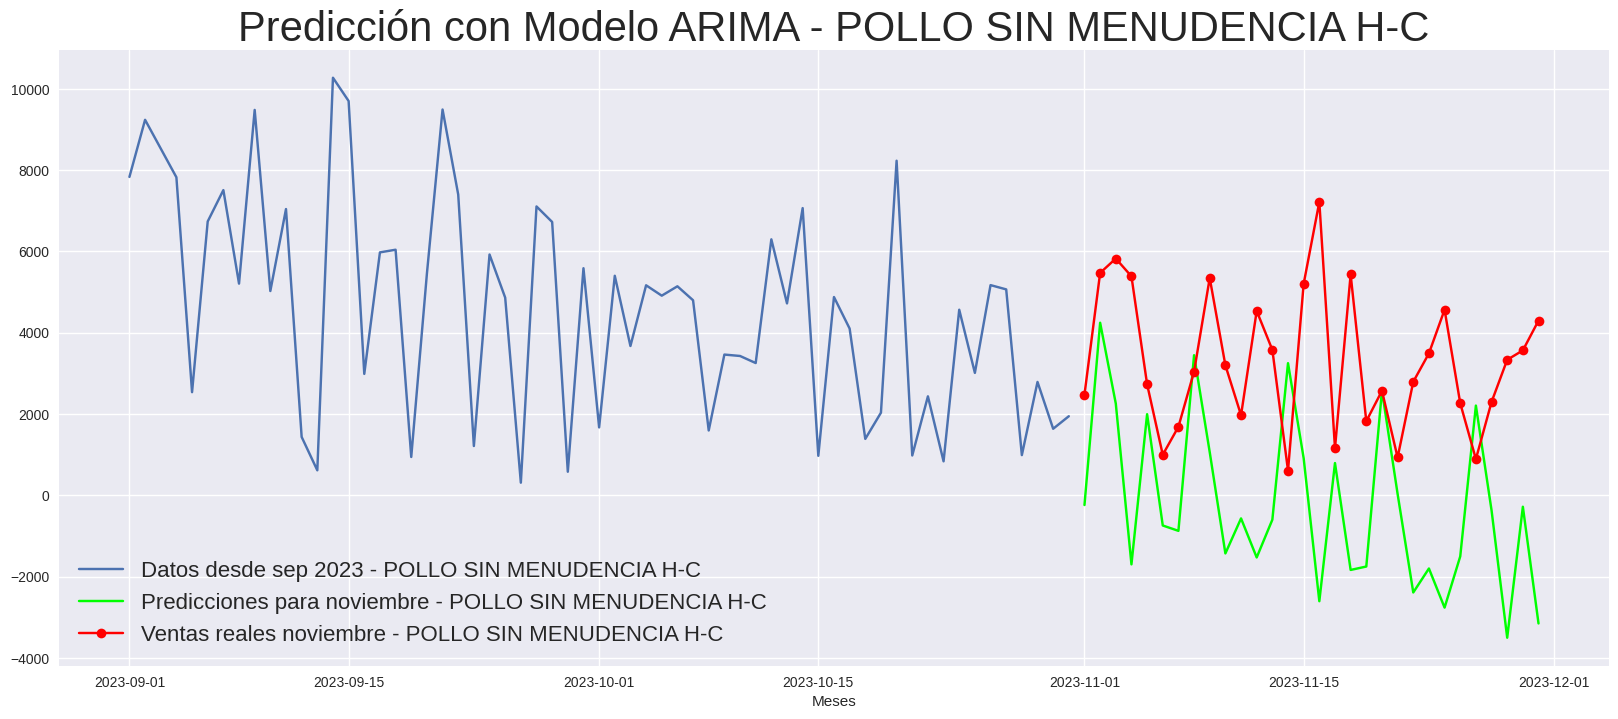

Predicciones para POLLO ESPECIAL:


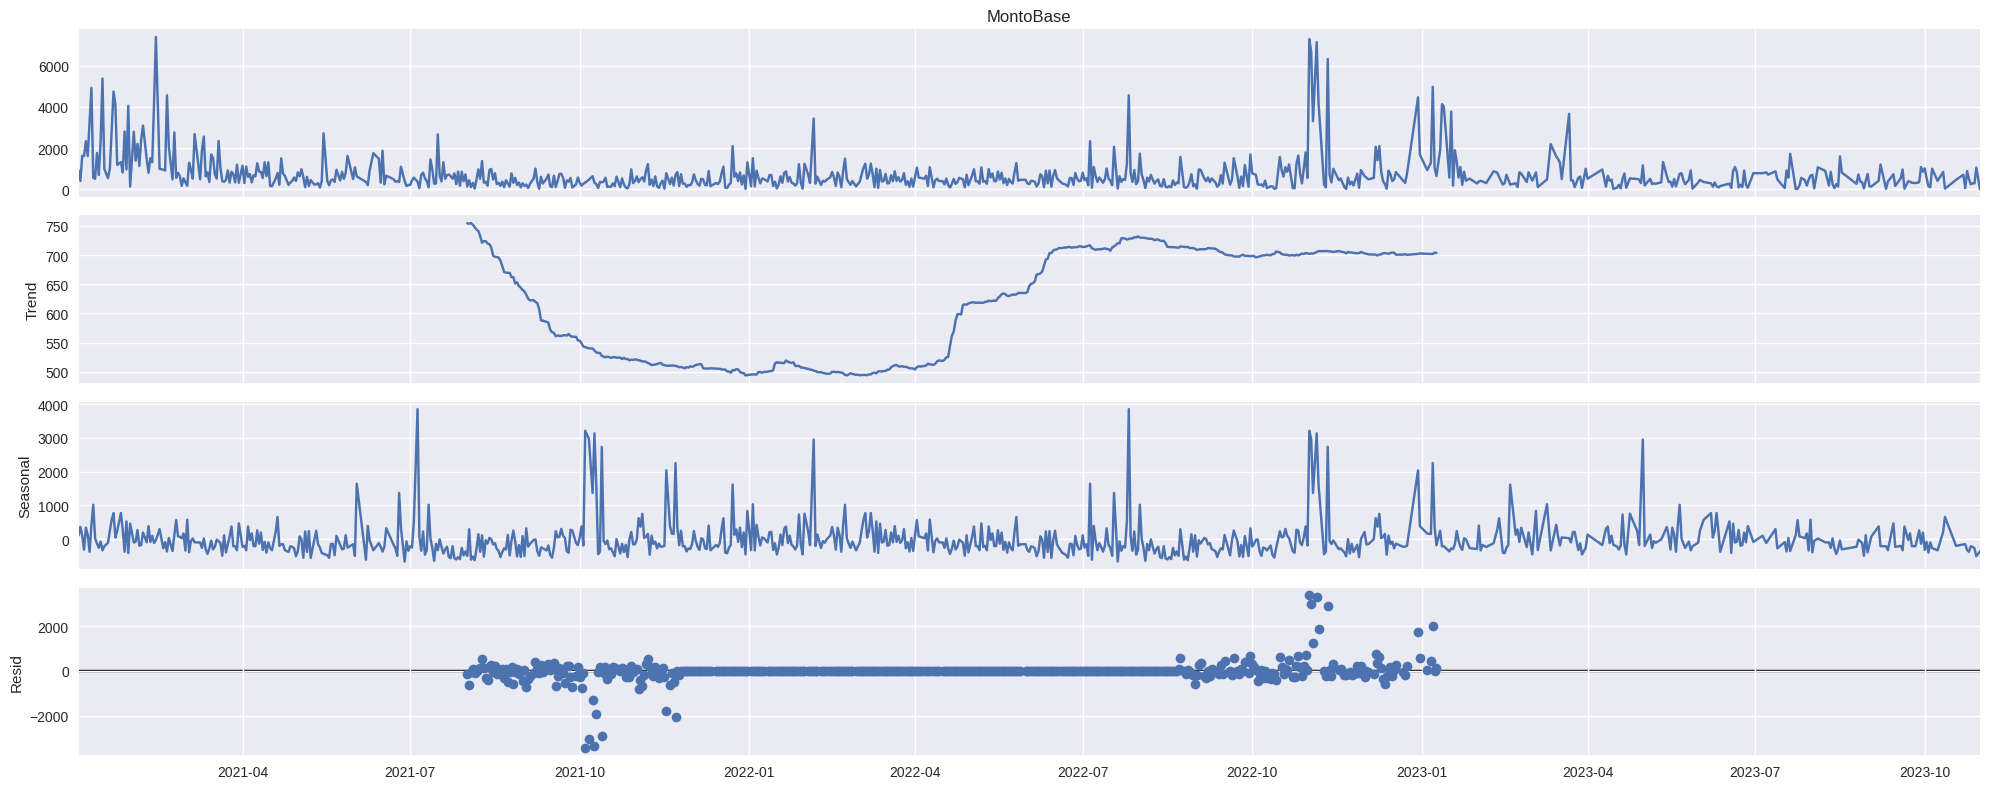

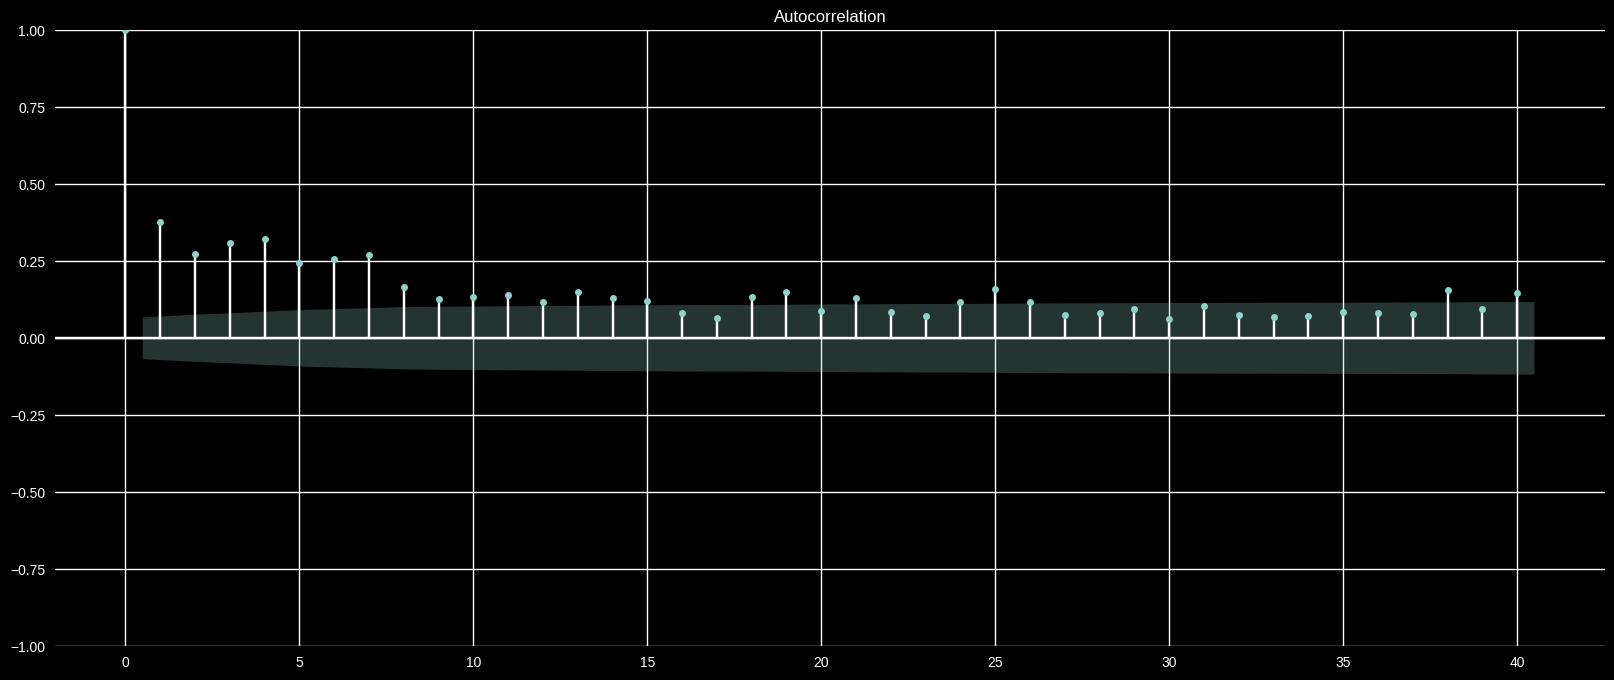

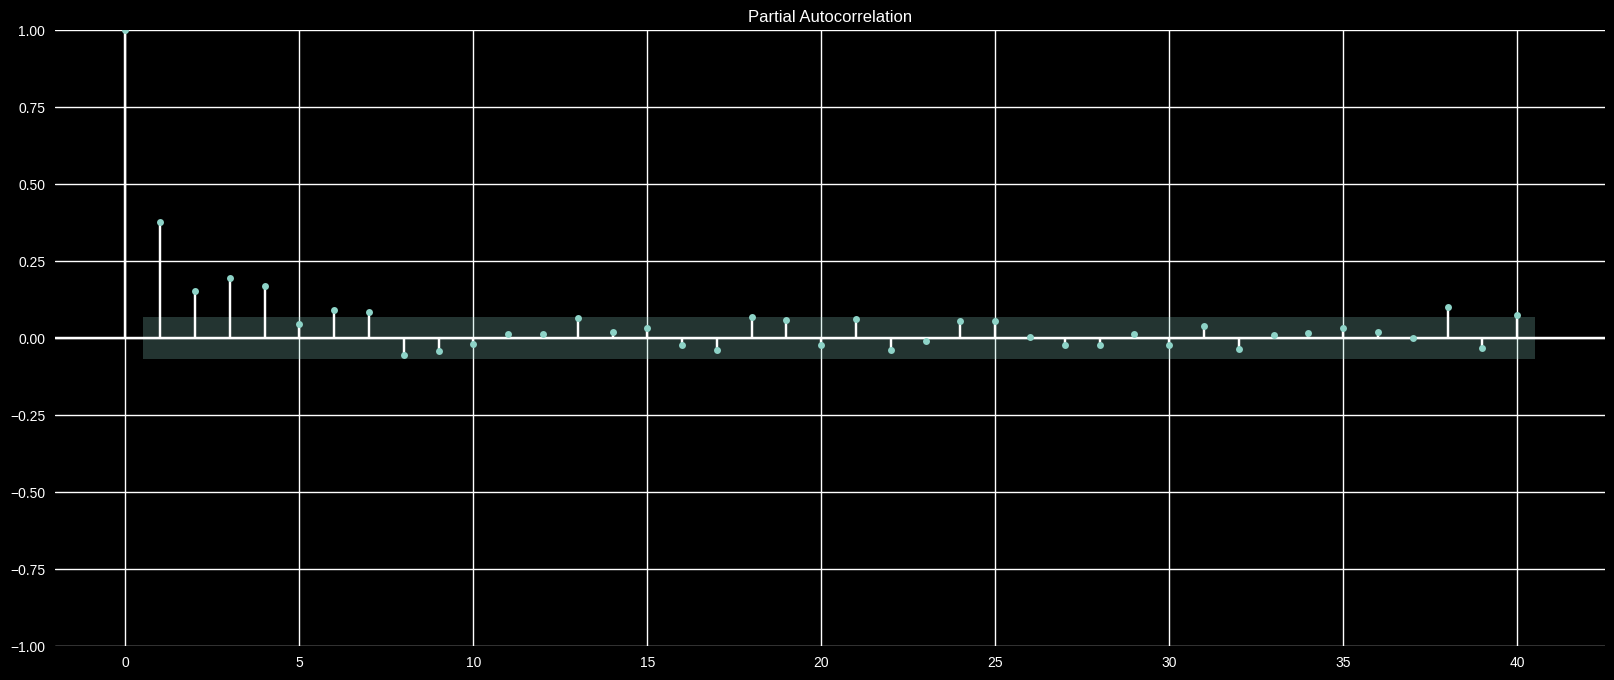

(807, 2) (31, 2)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=13774.594, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=13348.302, Time=2.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.44 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=13608.110, Time=0.13 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=13265.977, Time=5.68 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=11.32 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.57 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=13414.371, Time=5.31 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=13154.757, Time=8.68 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=13248.509, Time=4.60 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=23.65 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=6.30 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=13100.637, Time=7.54 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=13182.929, Time=5.29 sec
 ARIMA(3,1,0)(2,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

2023-09-11    176.3441
2023-09-12    415.9941
2023-09-13    542.4887
2023-09-14    797.0471
2023-09-15    -32.8066
2023-09-16    243.3754
2023-09-17    173.0669
2023-09-18     72.8385
2023-09-19    113.1980
2023-09-20     37.1466
2023-09-21    934.8406
2023-09-22    364.3530
2023-09-23    206.7418
2023-09-24    229.8247
2023-09-25    474.7230
2023-09-26    474.3399
2023-09-27   -109.3326
2023-09-28    330.8283
2023-09-29    240.4845
2023-09-30    -86.4017
2023-10-01    -10.5142
2023-10-02     36.2335
2023-10-03   1079.6297
2023-10-04    202.0241
2023-10-05     35.1667
2023-10-06    285.2499
2023-10-07    288.9405
2023-10-08    378.1991
2023-10-09   -207.2908
2023-10-10    144.5447
Freq: D, Name: ARIMA Predictions POLLO ESPECIAL, dtype: float64

Ventas reales y predicciones ARIMA para POLLO ESPECIAL:
                 MontoBase  P-V_ARIMA_POLLO ESPECIAL
FechaMovimiento                                     
2023-11-01        411.2423                 -128.3151
2023-11-02        550.9990    

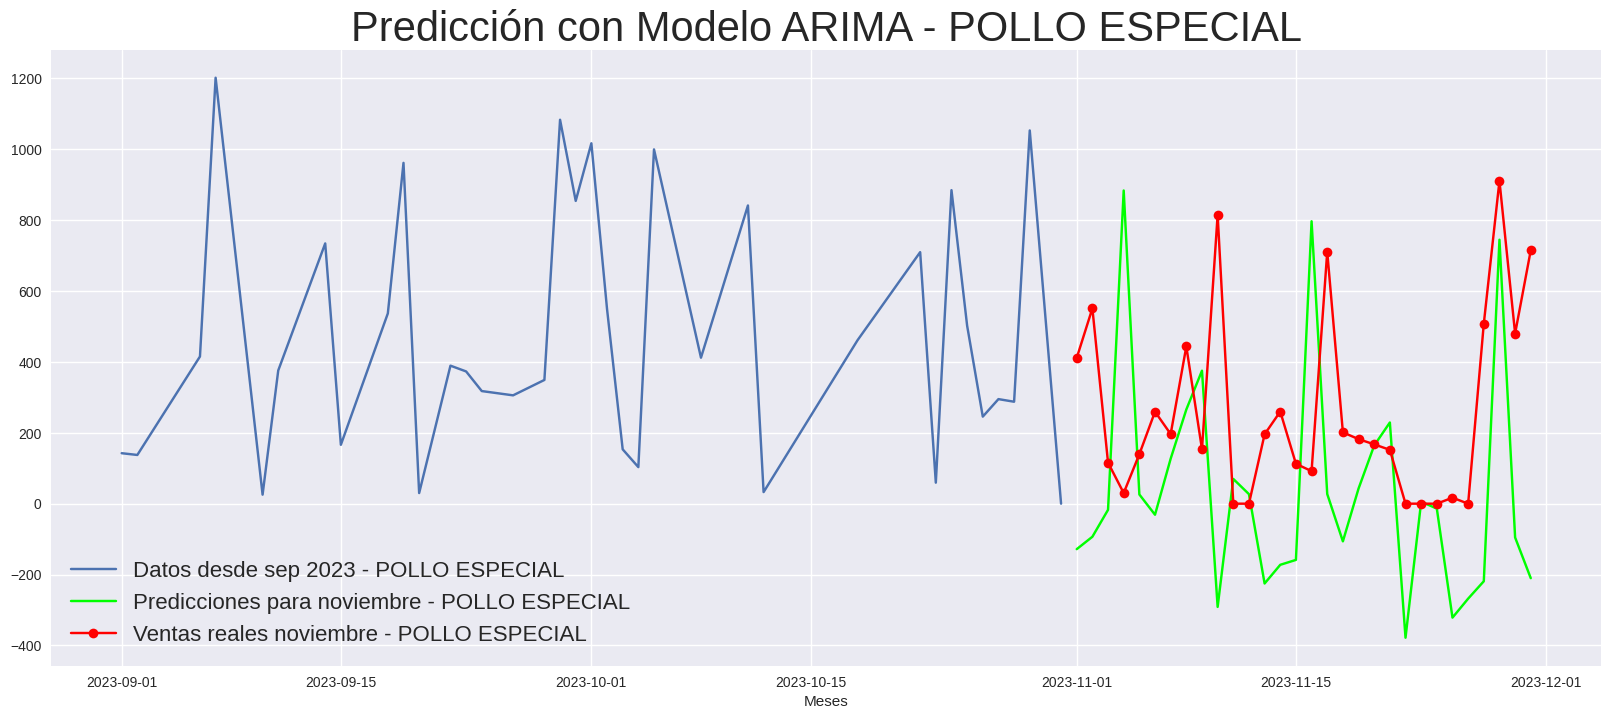

Predicciones para FILETE A GRANEL:


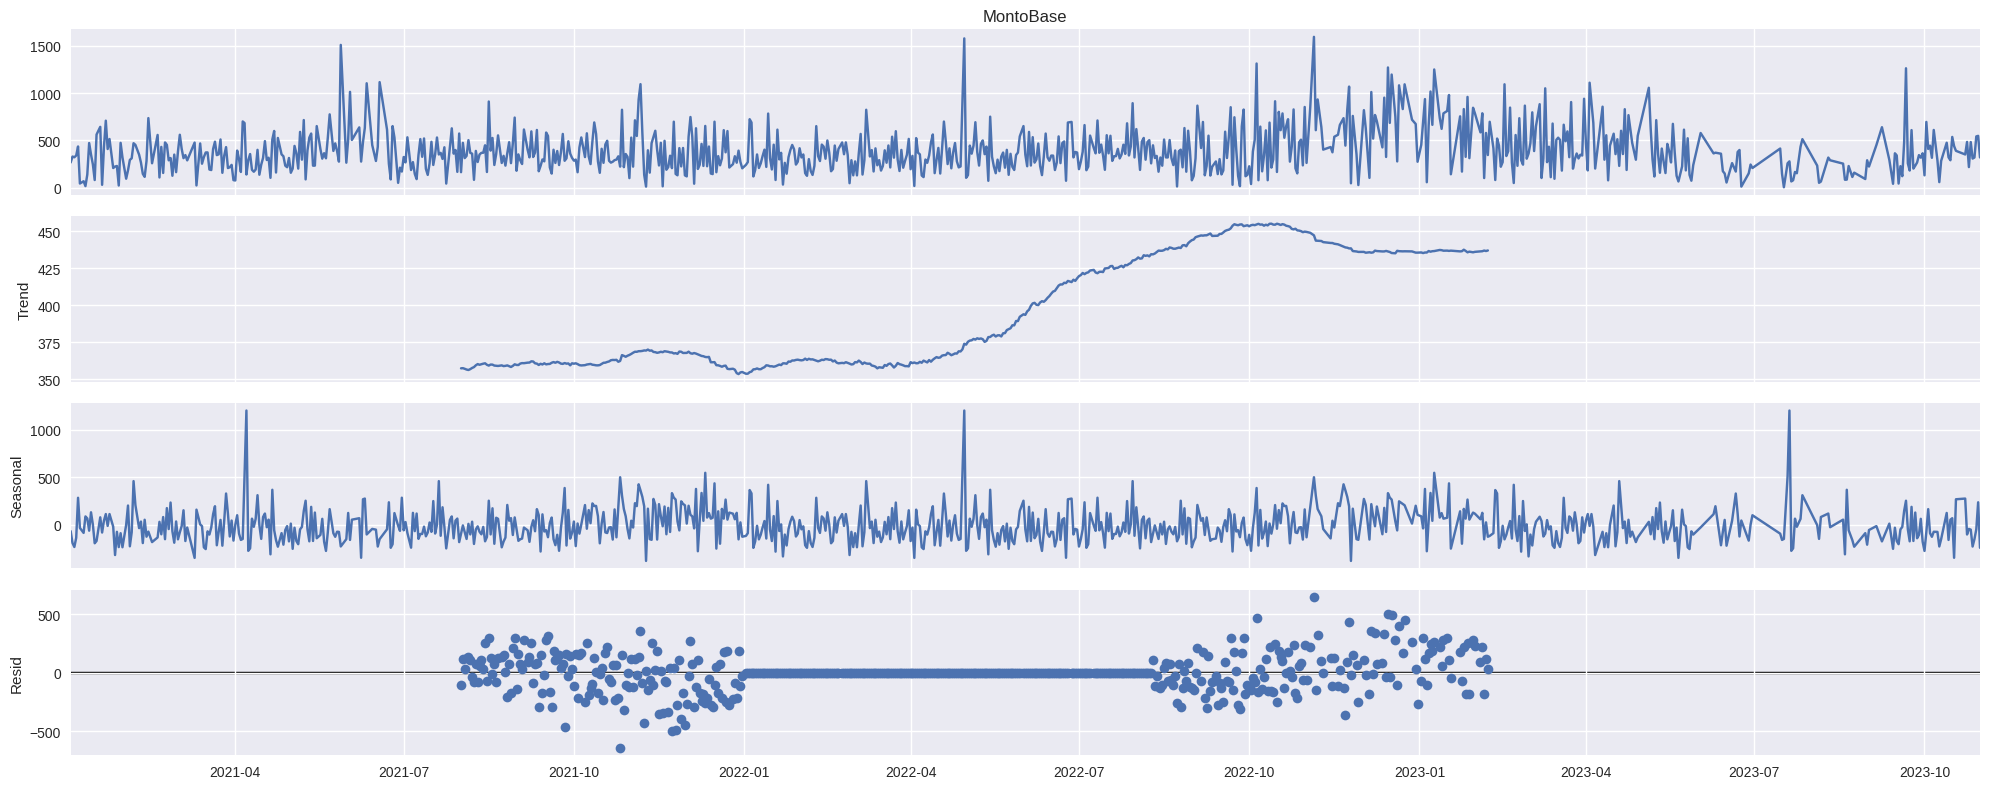

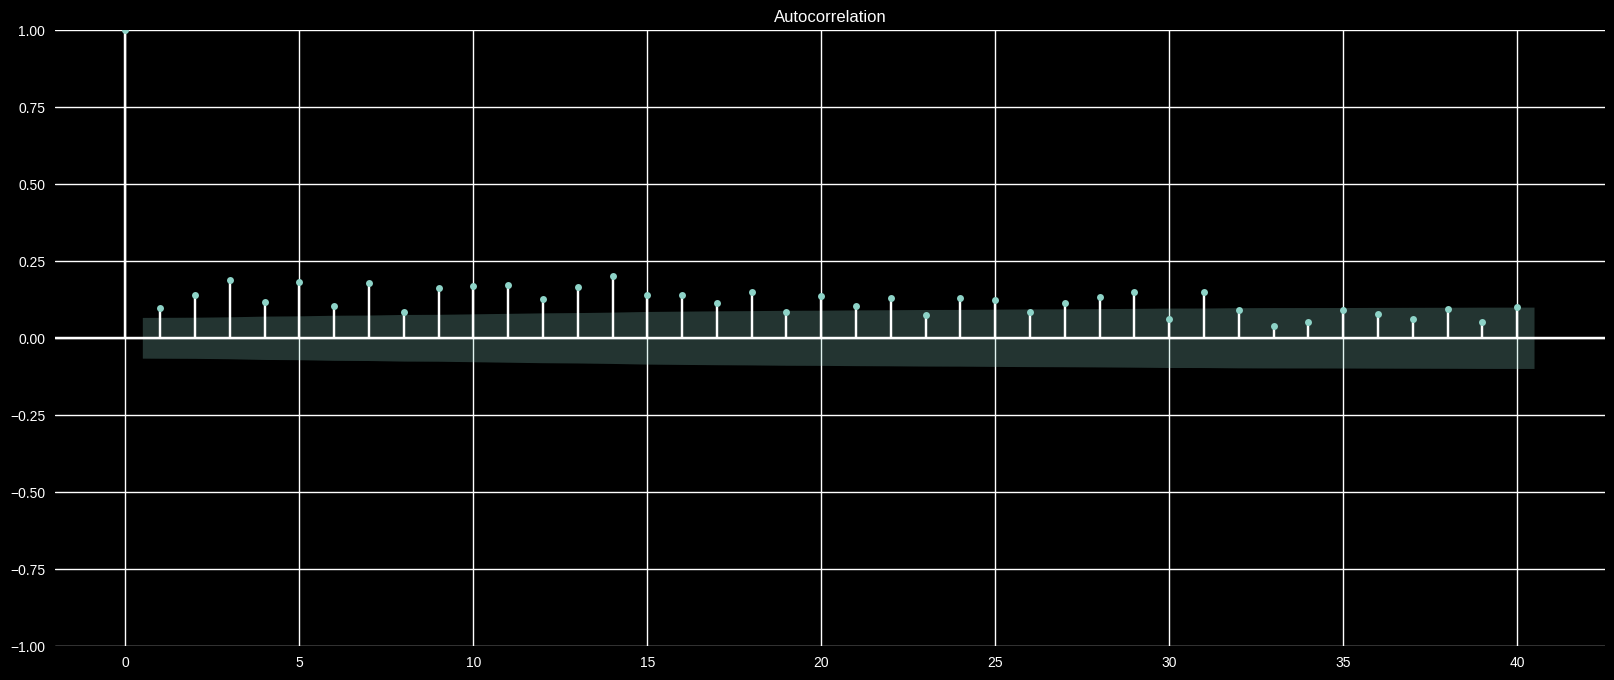

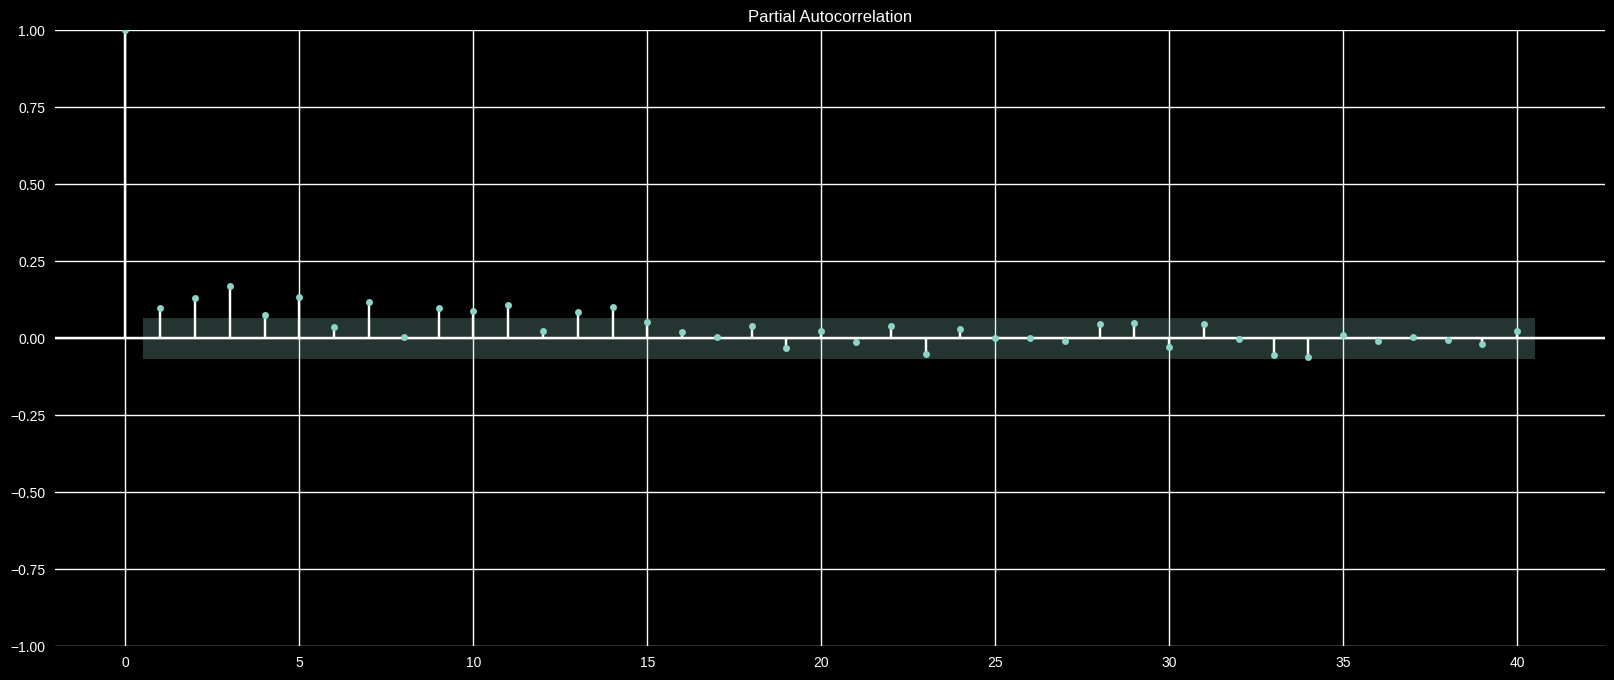

(847, 2) (31, 2)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=12611.593, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=12071.612, Time=0.85 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.44 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=12360.624, Time=0.14 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=11970.415, Time=2.68 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=7.92 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.66 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=12235.288, Time=0.92 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=11834.900, Time=3.42 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=11940.605, Time=1.25 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=13.03 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.65 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=11803.666, Time=2.91 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=11902.705, Time=1.44 sec
 ARIMA(3,1,0)(2,1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

2023-09-24    567.0955
2023-09-25    471.2741
2023-09-26    508.5528
2023-09-27    419.1060
2023-09-28    320.6688
2023-09-29    367.2798
2023-09-30    389.1307
2023-10-01    467.1177
2023-10-02    582.7874
2023-10-03    780.9294
2023-10-04    391.9109
2023-10-05    462.6987
2023-10-06    732.2696
2023-10-07    569.3207
2023-10-08    476.3969
2023-10-09    506.8670
2023-10-10    470.5920
2023-10-11    426.4818
2023-10-12    459.9487
2023-10-13    460.9165
2023-10-14    601.0891
2023-10-15   1010.8015
2023-10-16    508.7035
2023-10-17    579.2552
2023-10-18    863.6228
2023-10-19    663.2215
2023-10-20    563.4154
2023-10-21    649.1609
2023-10-22    595.0599
2023-10-23    498.3013
Freq: D, Name: ARIMA Predictions FILETE A GRANEL, dtype: float64

Ventas reales y predicciones ARIMA para FILETE A GRANEL:
                 MontoBase  P-V_ARIMA_FILETE A GRANEL
FechaMovimiento                                      
2023-11-01        260.2680                   570.9773
2023-11-02        626.915

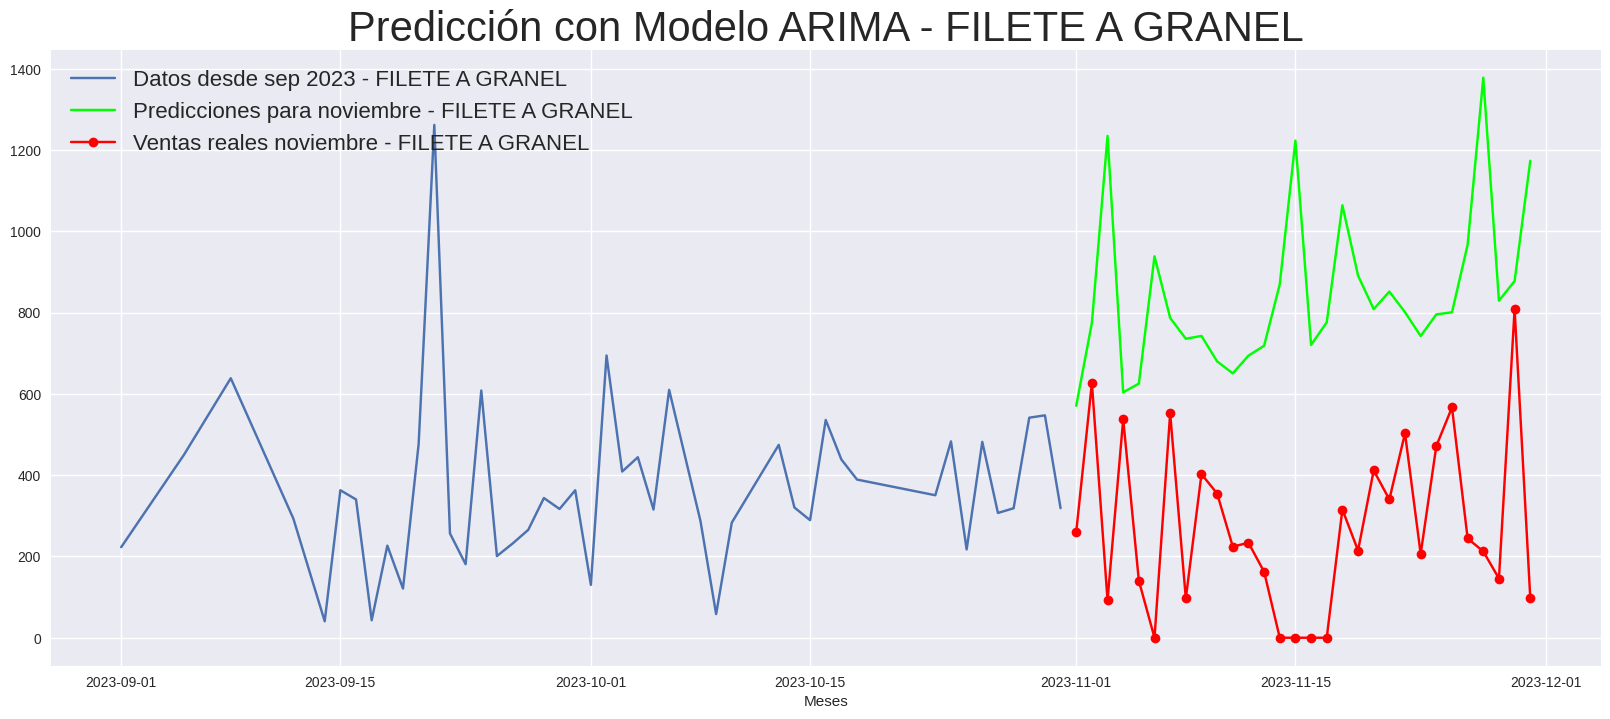

In [49]:
# Configurar tamaño de las figuras
plt.rcParams["figure.figsize"] = (12, 8)

# Iterar sobre los DataFrames en el objeto dfs_de_productos_sumados_arima
arima_models = {}  # Diccionario para almacenar los modelos ARIMA de cada producto

# Iterar sobre los DataFrames en el objeto dfs_de_productos_sumados_arima
for product, product_df_arima in dfs_de_productos_sumados_arima.items():
    if len(product_df_arima) >= 365:
        # Aquí puedes poner el código para realizar la predicción con ARIMA
        print(f"Predicciones para {product}:")
        # Realizar descomposición estacional
        decomposition = seasonal_decompose(product_df_arima["MontoBase"], model="add", period=365)
        decomposition.plot();
        plt.show()

        # Visualizar ACF y PACF
        plt.style.use('dark_background')
        plot_acf(product_df_arima['MontoBase'], lags=40)
        plt.show()

        plot_pacf(product_df_arima['MontoBase'], lags=40)
        plt.show()

        # Dividir en orden cronológico, entrenando sin el mes de octubre
        train_size_arima = int(len(product_df_arima) - 31)
        train_arima, test_arima = product_df_arima[0:train_size_arima], product_df_arima[train_size_arima:]

        print(train_arima.shape, test_arima.shape)

        # Identificar el modelo ARIMA automáticamente
        modelo_auto = auto_arima(train_arima['MontoBase'],
                                 start_p=0, d=1, start_q=0,
                                #  max_p=5, max_d=2, max_q=5,
                                 start_P=0, D=1, start_Q=0,
                                #  max_P=2, max_D=1, max_Q=2,
                                 seasonal=True, m=12, trace=True,
                                 error_action='ignore', suppress_warnings=True, stepwise=True,
                                 random_state=20, n_fits=50
                                 )
        print(modelo_auto.summary())

        # Configurar el modelo ARIMA
        arima_model = SARIMAX(train_arima["MontoBase"], order=modelo_auto.order, seasonal_order=modelo_auto.seasonal_order)
        arima_result = arima_model.fit()
        arima_models[product] = arima_result  # Guardar el modelo en el diccionario

        # Hacer predicciones con ARIMA
        # arima_pred = arima_result.predict(start = len(product_df_arima) ,end=len(product_df_arima)+29, typ="levels").rename(f"ARIMA Predictions {product}")
        arima_pred = arima_result.predict(start=len(train_arima), end=len(train_arima) + 29, typ="levels").rename(f"ARIMA Predictions {product}")

        # Crear un índice para las predicciones de noviembre
        # november_index = pd.date_range(start=train_arima.index[-1] + pd.DateOffset(1), periods=30)
        november_index = pd.date_range(start=test_arima.index[0], periods=30)
        arima_pred.index = november_index

        # print(f'el ultimo indice_valor de los datos reales es: {len(train_arima)},')
        # print(f'se supone que deeria acabar 30 despues, pero la funcion indica: {len(train_arima) + 29} \n')

        # Imprimir las predicciones para el mes de noviembre
        print(arima_pred)

        # Agregar las predicciones al DataFrame original
        if product in arima_models:
            # Hacer predicciones con ARIMA para el DataFrame actual
            arima_pred_full = arima_models[product].predict(start=len(product_df_arima), end=len(product_df_arima) + 29, typ="levels").rename(f"P-V_ARIMA_{product}")

            # Asegurarse de que las predicciones se alineen correctamente con las fechas de noviembre
            arima_pred_full.index = dfs_noviembre_sumados[product].index

            # Agregar la columna de predicciones ARIMA al DataFrame actual
            dfs_noviembre_sumados[product][f"P-V_ARIMA_{product}"] = arima_pred_full

            # Imprimir el resultado
            print(f'\nVentas reales y predicciones ARIMA para {product}:')
            print(dfs_noviembre_sumados[product][['MontoBase', f'P-V_ARIMA_{product}']].head(20))
        else:
            print(f"No hay modelo ARIMA para {product}.")

        # Visualizar las predicciones y los datos reales
        plt.style.use('seaborn')
        plt.rcParams["figure.figsize"] = (20, 8)
        # Datos de venta desde el 1ro de septiembre de 2023
        # Convertir la cadena a un objeto datetime.date
        start_date = datetime.strptime('2023-09-01', '%Y-%m-%d').date()
        end_date = datetime.strptime('2023-11-30', '%Y-%m-%d').date()
        plt.plot(product_df_arima.index[product_df_arima.index >= start_date], product_df_arima['MontoBase'][product_df_arima.index >= start_date], label='Datos desde sep 2023 - ' + product)
        # Predicciones para el futuro (noviembre)
        dates_future = pd.date_range(start='2023-11-01', periods=len(arima_pred_full))
        plt.plot(dates_future[:len(arima_pred_full)], arima_pred_full, color="lime", label='Predicciones para noviembre - ' + product)
        real_november_data = dfs_noviembre_sumados[product]
        plt.plot(real_november_data.index, real_november_data['MontoBase'], 'o-', color='red', label='Ventas reales noviembre - ' + product)
        plt.title(f"Predicción con Modelo ARIMA - {product}", fontsize=30)
        plt.xlabel('Meses')
        plt.ylabel('')
        plt.legend(fontsize=16)
        plt.show()
    else:
        print(f"No hay suficientes datos para hacer una predicción con ARIMA para {product}.")

In [50]:
# print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'])
print(list(dfs_de_productos_sumados_arima.values())[1].dtypes)
print(list(dfs_noviembre_sumados.values())[1].dtypes)

NombreProducto     object
MontoBase         float64
dtype: object
NombreProducto                 object
MontoBase                     float64
P-V_PROPHET_POLLO ESPECIAL    float64
P-V_LSTM_POLLO ESPECIAL       float32
P-V_ARIMA_POLLO ESPECIAL      float64
dtype: object


## Evaluar ARIMA

In [51]:
for product, product_df in dfs_noviembre_sumados.items():
    # print(product_df.head(30))

    # Verificar si la columna 'P-V_ARIMA_{product}' existe
    if f'P-V_ARIMA_{product}' in dfs_noviembre_sumados[product].columns:
        print(f'evaluacion del producto: {product}')
        # Puedes acceder a cada DataFrame individualmente para realizar evaluaciones métricas
        evaluacion_metrica(
            dfs_noviembre_sumados[product]['MontoBase'],
            dfs_noviembre_sumados[product][f'P-V_ARIMA_{product}']
        )
        print('\n')
    else:
        print(f"No hay predicciones para {product}.")

evaluacion del producto: POLLO SIN MENUDENCIA H-C
Evaluation metric results:  
MSE is : 20658882.119737227
MAE is : 3810.0049707562303
R2 is : -6.164489271004861 %
------------------------------
MRSE is : 4545.204299009806
MAPE is : 127.50484126223043 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------




evaluacion del producto: POLLO ESPECIAL
Evaluation metric results:  
MSE is : 215252.80844750156
MAE is : 356.12840623006383
R2 is : -2.1582515943379184 %
------------------------------
MRSE is : 463.953455044255
MAPE is : 330.4979025053148 %
------------------------------
------------------------------
Días reales calculados: 24
Días omitidos: 6
Total de días: 30
------------------------------




evaluacion del producto: FILETE A GRANEL
Evaluation metric results:  
MSE is : 426557.3776624204
MAE is : 570.3034895333809
R2 is : -8.708108435146487 %
------------------------------
M

Cómo interpretar las gráficas de residuos en el modelo ARIMA


# PREDICCIONES
### Graficos y valores calculados de (todos) los productos


<ipython-input-52-18dcb7d60c8b>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


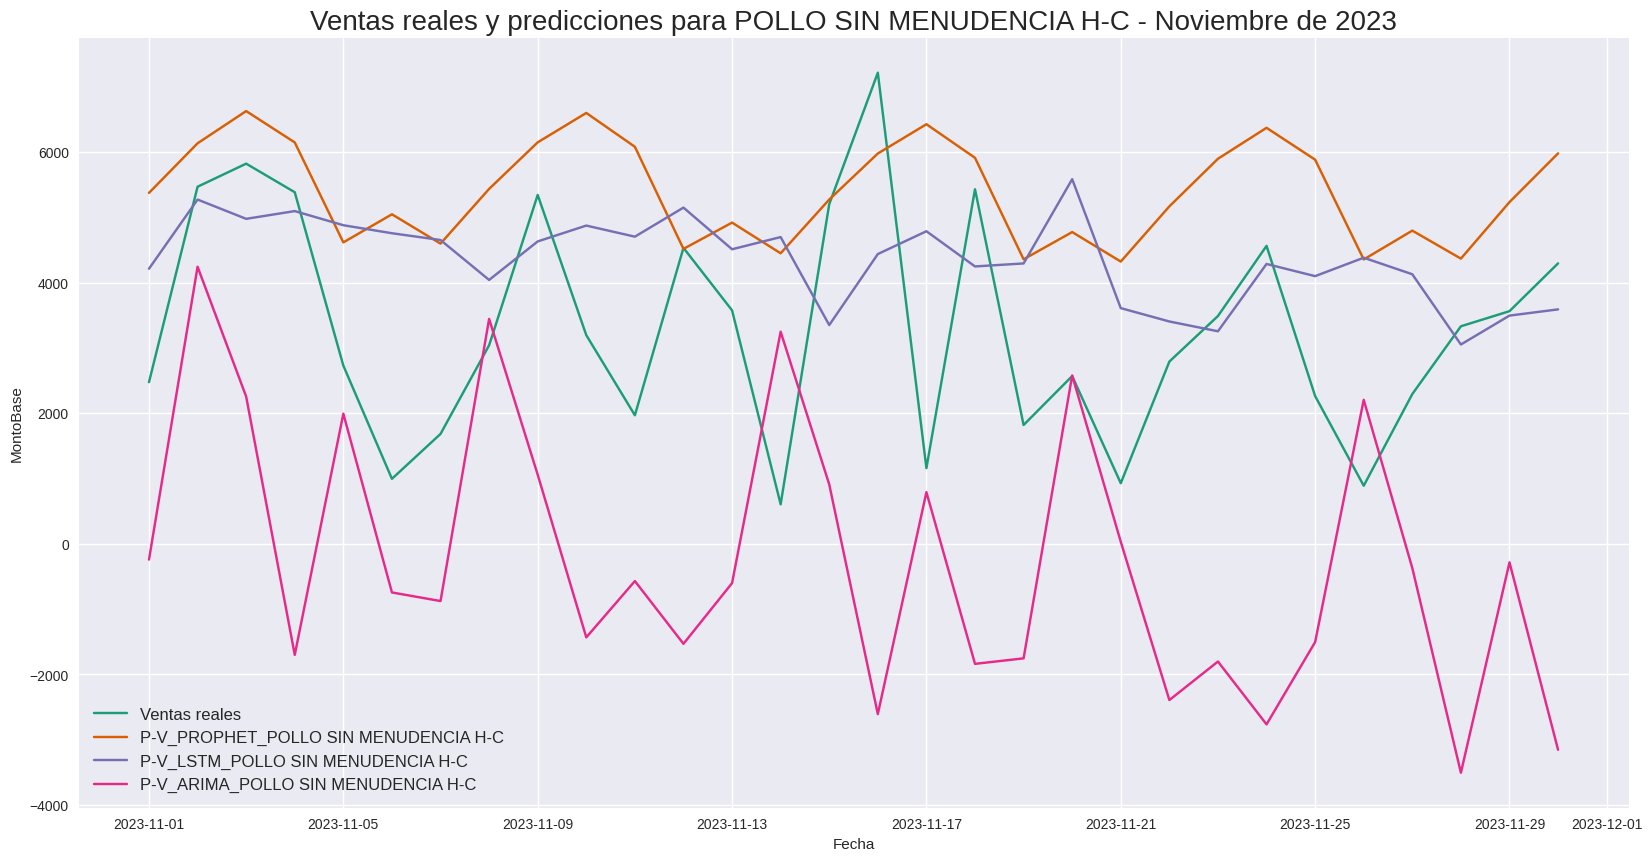

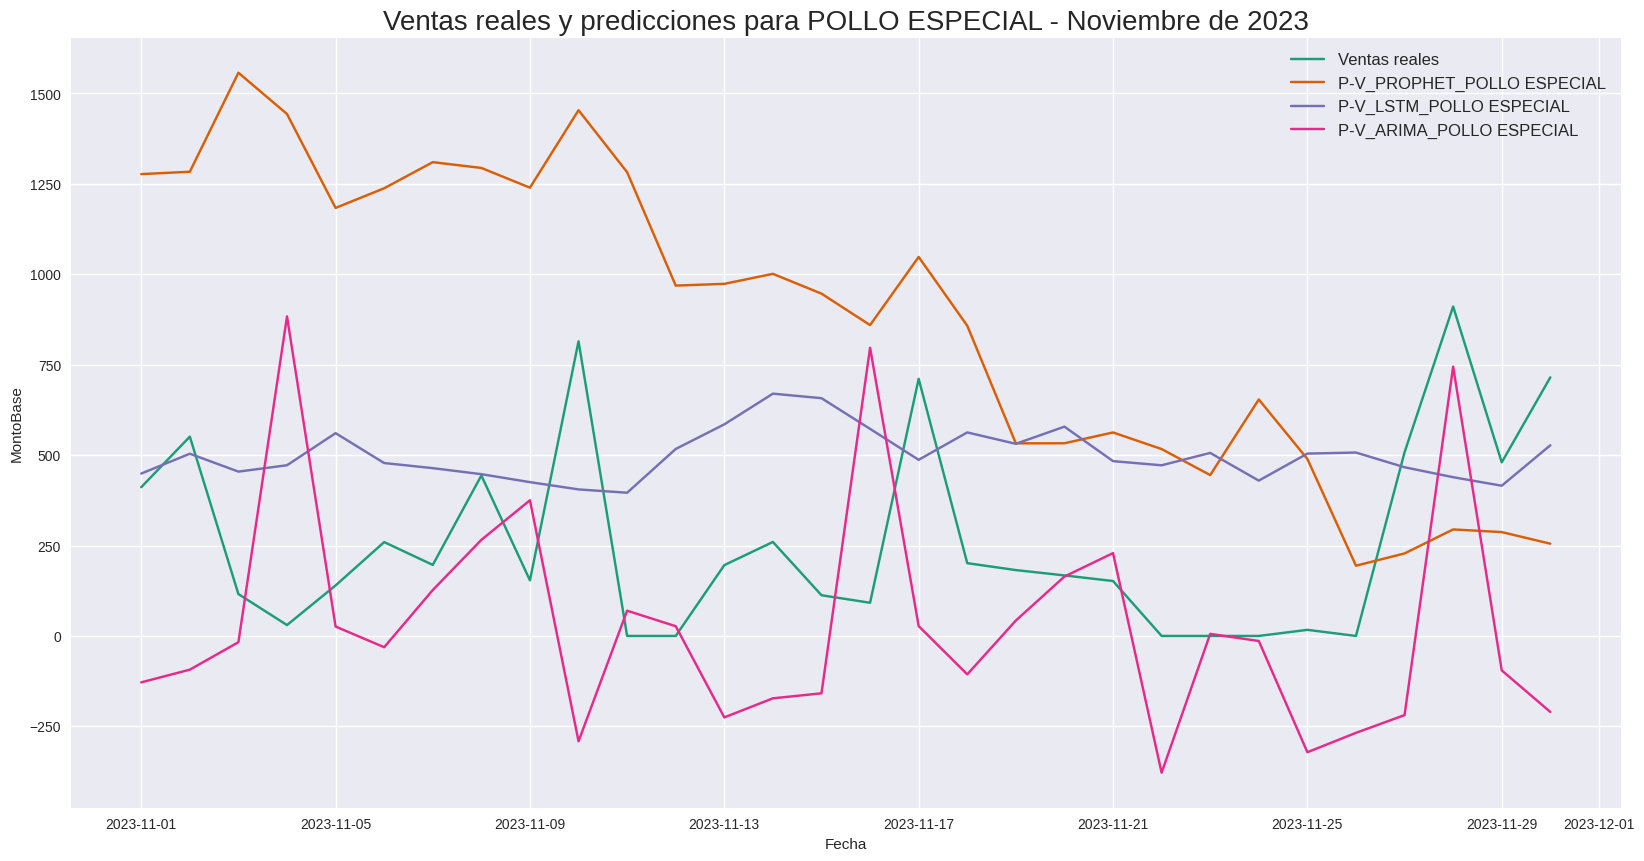

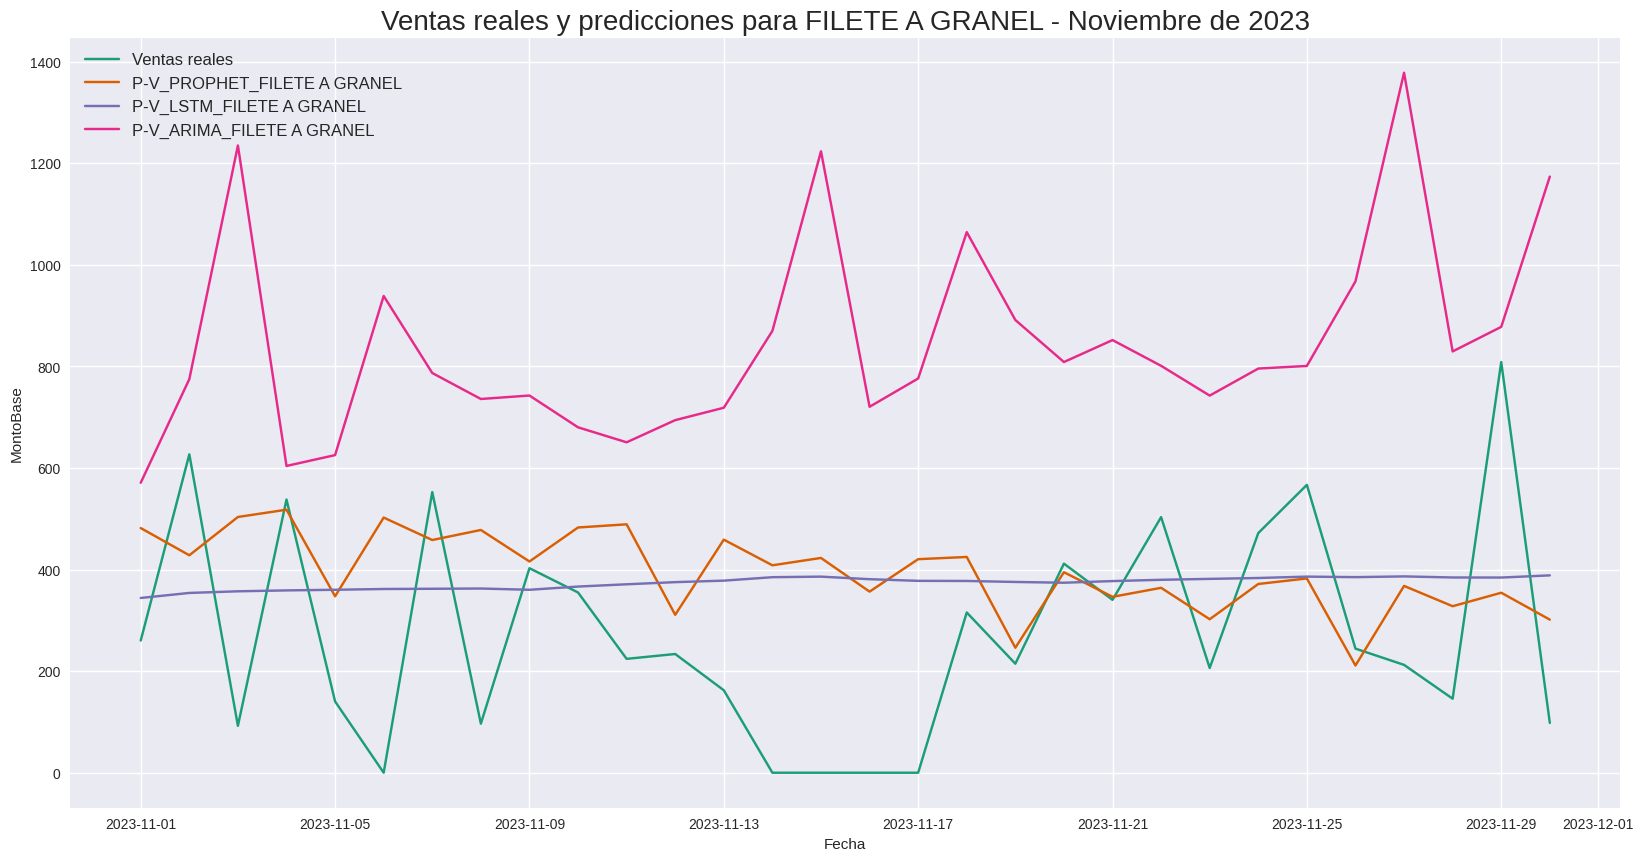

In [52]:
# Obtener la lista de productos
productos = list(dfs_noviembre_sumados.keys())

# Configurar el gráfico
plt.style.use('seaborn')
sns.set_palette("Dark2")
# Iterar sobre los productos
for product in productos:
    # Obtener los datos del producto actual
    product_data = dfs_noviembre_sumados[product]

    # Verificar si hay predicciones disponibles para el producto
    predicciones_disponibles = [col for col in product_data.columns if 'P-V_' in col]

    if not predicciones_disponibles:
        # No hay predicciones disponibles para el producto, omitir el gráfico
        continue

    # Configurar el gráfico para el producto actual
    plt.figure(figsize=(20, 10))
    plt.plot(product_data.index, product_data['MontoBase'], label='Ventas reales')

    # Graficar todas las predicciones disponibles
    for pred in predicciones_disponibles:
        plt.plot(product_data.index, product_data[pred], label=pred)

    # Configurar etiquetas y leyenda
    plt.title(f'Ventas reales y predicciones para {product} - Noviembre de 2023', fontsize=20)
    plt.xlabel('Fecha')
    plt.ylabel('MontoBase')
    plt.legend(fontsize=12)
    plt.show()

In [53]:
# Iterar sobre los productos
for product, product_df in dfs_noviembre_sumados.items():
    print(f'Evaluación del producto: {product}')

    # Verificar si hay predicciones disponibles para el producto
    predicciones_disponibles = [col for col in product_df.columns if 'P-V_' in col]

    if not predicciones_disponibles:
        # No hay predicciones disponibles para el producto
        print(f"No hay predicciones para {product}.")
        continue

    # Calcular métricas de evaluación para cada predicción disponible
    for pred in predicciones_disponibles:
        # Extraer el nombre del modelo de la columna de predicciones
        nombre_modelo = pred.split('_')[1]

        y_real = product_df['MontoBase']
        y_pred = product_df[pred]

        print(f'Modelo: {nombre_modelo}')
        evaluacion_metrica(y_real, y_pred)

    print("\n\n")

Evaluación del producto: POLLO SIN MENUDENCIA H-C
Modelo: PROPHET
Evaluation metric results:  
MSE is : 6506427.42390741
MAE is : 2189.369466286879
R2 is : -1.2564255510524864 %
------------------------------
MRSE is : 2550.7699668742007
MAPE is : 131.00143323676363 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------


Modelo: LSTM
Evaluation metric results:  
MSE is : 4313989.825860251
MAE is : 1689.225374166667
R2 is : -0.496089364538812 %
------------------------------
MRSE is : 2077.014642668715
MAPE is : 108.18113193850792 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------


Modelo: ARIMA
Evaluation metric results:  
MSE is : 20658882.119737227
MAE is : 3810.0049707562303
R2 is : -6.164489271004861 %
------------------------------
MRSE is : 4545.204299009806
MAPE is : 127.5

In [54]:
for product, product_df in dfs_noviembre_sumados.items():
    print(product_df)

                           NombreProducto  MontoBase  \
FechaMovimiento                                        
2023-11-01       POLLO SIN MENUDENCIA H-C  2476.3271   
2023-11-02       POLLO SIN MENUDENCIA H-C  5469.8955   
2023-11-03       POLLO SIN MENUDENCIA H-C  5823.3412   
2023-11-04       POLLO SIN MENUDENCIA H-C  5385.7282   
2023-11-05       POLLO SIN MENUDENCIA H-C  2729.9860   
2023-11-06       POLLO SIN MENUDENCIA H-C   996.0257   
2023-11-07       POLLO SIN MENUDENCIA H-C  1683.6664   
2023-11-08       POLLO SIN MENUDENCIA H-C  3041.4504   
2023-11-09       POLLO SIN MENUDENCIA H-C  5344.3076   
2023-11-10       POLLO SIN MENUDENCIA H-C  3196.6041   
2023-11-11       POLLO SIN MENUDENCIA H-C  1969.6056   
2023-11-12       POLLO SIN MENUDENCIA H-C  4533.3930   
2023-11-13       POLLO SIN MENUDENCIA H-C  3576.5896   
2023-11-14       POLLO SIN MENUDENCIA H-C   605.9921   
2023-11-15       POLLO SIN MENUDENCIA H-C  5202.4149   
2023-11-16       POLLO SIN MENUDENCIA H-C  7216.